# Implementación de SGD para la función XOR

In [67]:
import numpy as np
import matplotlib.pyplot as plt

## Función sigmoidea

In [68]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

## Función de pérdida

In [69]:
def loss(y, y_pred):
  diff = y - y_pred
  return np.mean(diff**2)

## Función de predicción

In [70]:
def predict(x, w):
  
  # Reordeno vector de parametros como matriz de 3x3, donde cada columna contiene los parámetro de cada neurona
  W = np.reshape(w, (3, 3)).T

  # Calculo z para las neuronas de la capa 1
  z_L1 = x @ W[:, :-1]
  # Calculo la salida para las neuronas de la capa 1 (incluyendo termino independiente)
  a_L1 = np.append(sigmoid(z_L1), np.array([1]))

  # Calculo salida de la neurona de la capa 2
  z_L2 = np.dot(a_L1, W[:, -1]) #Prediccion para la i-esima fila del dataset

  return [z_L2, a_L1, z_L1, W]

In [71]:
y_true=.23434445
x=np.array([2, 5, 1])
w=np.random.rand(9)
fwd = predict(x,w)
print(fwd)

[0.8418530148483232, array([0.92164696, 0.98679232, 1.        ]), array([2.46493745, 4.31366098]), array([[0.47582002, 0.43713193, 0.17355064],
       [0.2334537 , 0.50122918, 0.00974602],
       [0.34602891, 0.93325124, 0.67228329]])]


## Función para calcular el gradiente de la función de perdida respecto a los parámetros del modelo

In [72]:
def gradient(x, err, pred_vars):
  # Derivada de loss respecto a la y_pred
  dL_dypred = -2*err
  z_L2, a_L1, z_L1, W = pred_vars[0], pred_vars[1], pred_vars[2], pred_vars[3]
  
  # Derivada respecto a los parámetros de la capa L2
  dL_w2b2 = dL_dypred*a_L1

  # Derivada respecto a los parámetros de la capa L1
  dypred_da1 = W[0:2, -1]
  da1_dz1 = sigmoid(z_L1)*(1-sigmoid(z_L1))
  dypred_dz1 = dypred_da1*da1_dz1
  dL_w1b1 = dL_dypred*np.tensordot(x, dypred_dz1, axes=0)

  # Gradiente
  gradJ = np.reshape(dL_w1b1.T, (6,)) #Primero debo trasponer para que la salida sea el apilamiento de las columnas de la matriz
  gradJ = np.append(gradJ, dL_w2b2)
  
  return gradJ

In [73]:
grad1 = gradient(x,y_true-fwd[0],fwd)
print(grad1)

[3.04550332e-02 7.61375830e-02 1.52275166e-02 3.08668403e-04
 7.71671007e-04 1.54334201e-04 1.11981684e+00 1.19896957e+00
 1.21501713e+00]


## Derivada numerica

In [74]:
def NumDiff(y, y_pred0, x, w0):
  nw = len(w0)
  dw = 1e-6
  f0 = loss(y, y_pred0)
  grad = []
  for i in range(nw):
    w = np.copy(w0)
    w[i] = w[i] + dw
    pred = predict(x, w)
    y_pred = pred[0]
    f = loss(y, y_pred)
    df_dw = (f-f0)/dw
    grad.append(df_dw)

  return np.asarray(grad)


In [75]:
grad2 = NumDiff(y_true, fwd[0], x, w)
print(grad2)

[3.04550082e-02 7.61374264e-02 1.52275104e-02 3.08668091e-04
 7.71669229e-04 1.54334101e-04 1.11981769e+00 1.19897054e+00
 1.21501813e+00]


## Comprobación entre derivada numérica y derivada calculada por diferenciacion automática

In [76]:
grad1/grad2

array([1.00000082, 1.00000206, 1.00000041, 1.00000101, 1.00000231,
       1.00000065, 0.99999924, 0.99999919, 0.99999918])

## Algortimo SGD

In [77]:
def sgd(X, y, w, lr, epochs):
  N, d = X.shape
  MSE = []
  for i in range(epochs):
    for j in range(N):
      # Selecciono fila j del dataset
      x_j = X[j,:]
      # Selecciono componente j de la variable target
      y_j = y[j]
      # Paso forward utilizando la fila j
      pred_vars = predict(x_j, w)
      y_pred_j = pred_vars[0]
      # Calculo del residuo
      err_j = y_j - y_pred_j
      # Paso backpropagation
      gradJ = gradient(x_j, err_j, pred_vars)
      # Derivada numérica
      gradJ2 = NumDiff(y_j, y_pred_j, x_j, w) 
      # Comparacion backprop y derivada numerica
      #print("Derivada computada por backpropagation:", gradJ)
      #print("Derivada computada por diferencias finitas:", gradJ2)
      print("Relación entre las derivadas:", gradJ/gradJ2)
      # Actualizacion de pesos
      w = w - lr*gradJ
    
    y_pred = np.empty((N,))
    for j in range(N):
      pred_vars = predict(X[j,:], w)
      y_pred[j] = pred_vars[0]
    
    mse = loss(y, y_pred)
    MSE.append(mse)
    print("Epoch:", i, "MSE:", mse)

  return w, MSE

## Main - Minimización utilizando SGD en el problema de ajuste a la función XOR

In [78]:
# Dataset
X = np.array([[0, 0],
              [0, 1],
              [1, 0],
              [1, 1]])

N, d = X.shape

# Agrego columna de unos
X = np.append(X, np.ones((N,1)), axis=1)

# Variable target
y = np.array([0, 1, 1, 0])

# Arquitectura de la ANN
n_layers = 2
neuronas_L1 = 2
neuronas_L2 = 1

# Hiperparámetros del modelo
learningRates = np.linspace(0.1, 1, 10) # Learning rates
epochs = 300 # N° de iteraciones máximas de SGD

# Inicializacion random de los parámetros del modelo
n_param = 9
w0 = np.random.uniform(low=0.0, high=1.0, size=n_param)#np.random.rand(n_param)

# Llamada al algoritmo de Stochastic Gradient Descent para cada uno de los learning rate considerados
MSE = []
W = []
for lr in learningRates:
    w_i, MSE_i = sgd(X, y, w0, lr, epochs)
    W.append(w_i)
    MSE.append(MSE_i)

idx = np.argmin(MSE)
w = W[idx]



Relación entre las derivadas: [       nan        nan 1.00000006        nan        nan 1.00000026
 0.99999962 0.99999954 0.99999936]
Relación entre las derivadas: [       nan 1.00000016 1.00000016        nan 1.00000029 1.00000029
 1.00000062 1.00000079 1.00000097]
Relación entre las derivadas: [1.00000025        nan 1.00000025 1.00000028        nan 1.00000028
 1.00000118 1.00000136 1.0000017 ]
Relación entre las derivadas: [1.00000022 1.00000022 1.00000022 1.00000036 1.00000036 1.00000036
 0.99999956 0.99999949 0.99999941]
Epoch: 0 MSE: 0.2523039554419577
Relación entre las derivadas: [       nan        nan 1.00000007        nan        nan 1.00000024
 0.99999937 0.99999922 0.99999892]
Relación entre las derivadas: [       nan 1.00000014 1.00000014        nan 1.00000029 1.00000029
 1.00000044 1.00000056 1.00000069]
Relación entre las derivadas: [1.00000022        nan 1.00000022 1.00000028        nan 1.00000028
 1.00000082 1.00000095 1.00000119]
Relación entre las derivadas: [1.00000022 1

C:\Users\Asus\AppData\Local\Temp\ipykernel_14300\76714480.py:22: RuntimeWarning: invalid value encountered in true_divide
  print("Relación entre las derivadas:", gradJ/gradJ2)


Relación entre las derivadas: [       nan        nan 1.00000009        nan        nan 1.00000024
 0.99999934 0.99999918 0.99999884]
Relación entre las derivadas: [       nan 1.0000001  1.0000001         nan 1.00000027 1.00000027
 1.00000041 1.00000053 1.00000067]
Relación entre las derivadas: [1.00000019        nan 1.00000019 1.00000027        nan 1.00000027
 1.00000076 1.00000089 1.00000113]
Relación entre las derivadas: [1.0000002  1.0000002  1.0000002  1.00000023 1.00000023 1.00000023
 0.99999952 0.99999943 0.99999933]
Epoch: 13 MSE: 0.25687677868038306
Relación entre las derivadas: [       nan        nan 1.00000013        nan        nan 1.00000024
 0.99999934 0.99999918 0.99999884]
Relación entre las derivadas: [       nan 1.0000001  1.0000001         nan 1.00000027 1.00000027
 1.00000041 1.00000053 1.00000067]
Relación entre las derivadas: [1.00000019        nan 1.00000019 1.00000027        nan 1.00000027
 1.00000076 1.00000089 1.00000113]
Relación entre las derivadas: [1.0000002 

Relación entre las derivadas: [1.00000017 1.00000017 1.00000017 1.00000034 1.00000034 1.00000034
 0.99999954 0.99999943 0.99999932]
Epoch: 29 MSE: 0.25554450659977174
Relación entre las derivadas: [       nan        nan 1.00000007        nan        nan 1.00000023
 0.99999937 0.99999921 0.99999887]
Relación entre las derivadas: [       nan 1.00000006 1.00000006        nan 1.00000025 1.00000025
 1.00000039 1.00000052 1.00000068]
Relación entre las derivadas: [1.00000015        nan 1.00000015 1.00000026        nan 1.00000026
 1.00000072 1.00000085 1.0000011 ]
Relación entre las derivadas: [1.00000016 1.00000016 1.00000016 1.00000035 1.00000035 1.00000035
 0.99999954 0.99999943 0.99999932]
Epoch: 30 MSE: 0.2554675407189039
Relación entre las derivadas: [       nan        nan 1.00000007        nan        nan 1.00000023
 0.99999938 0.99999921 0.99999887]
Relación entre las derivadas: [       nan 1.00000006 1.00000006        nan 1.00000024 1.00000024
 1.00000039 1.00000052 1.00000068]
Relació

Relación entre las derivadas: [       nan        nan 1.00000007        nan        nan 1.00000021
 0.99999943 0.99999926 0.99999891]
Relación entre las derivadas: [       nan 0.99999998 0.99999998        nan 1.00000019 1.00000019
 1.00000036 1.00000051 1.00000071]
Relación entre las derivadas: [1.00000009        nan 1.00000009 1.00000023        nan 1.00000023
 1.00000065 1.0000008  1.00000106]
Relación entre las derivadas: [1.00000012 1.00000012 1.00000012 1.0000003  1.0000003  1.0000003
 0.99999958 0.99999945 0.9999993 ]
Epoch: 58 MSE: 0.25364323874007233
Relación entre las derivadas: [       nan        nan 1.00000007        nan        nan 1.00000021
 0.99999943 0.99999927 0.99999891]
Relación entre las derivadas: [       nan 0.99999998 0.99999998        nan 1.00000019 1.00000019
 1.00000036 1.00000051 1.00000071]
Relación entre las derivadas: [1.00000008        nan 1.00000008 1.00000022        nan 1.00000022
 1.00000065 1.00000079 1.00000106]
Relación entre las derivadas: [1.00000011 

Relación entre las derivadas: [1.00000005        nan 1.00000005 1.0000002         nan 1.0000002
 1.00000061 1.00000075 1.00000103]
Relación entre las derivadas: [1.00000008 1.00000008 1.00000008 1.00000025 1.00000025 1.00000025
 0.99999961 0.99999947 0.99999929]
Epoch: 81 MSE: 0.2526280215078464
Relación entre las derivadas: [       nan        nan 1.00000006        nan        nan 1.00000019
 0.99999946 0.9999993  0.99999893]
Relación entre las derivadas: [       nan 0.99999992 0.99999992        nan 1.00000014 1.00000014
 1.00000034 1.00000049 1.00000073]
Relación entre las derivadas: [1.00000004        nan 1.00000004 1.0000002         nan 1.0000002
 1.00000061 1.00000074 1.00000102]
Relación entre las derivadas: [1.00000007 1.00000007 1.00000007 1.00000025 1.00000025 1.00000025
 0.99999961 0.99999947 0.99999929]
Epoch: 82 MSE: 0.2525935591626663
Relación entre las derivadas: [       nan        nan 1.00000006        nan        nan 1.00000019
 0.99999946 0.9999993  0.99999893]
Relación e

Relación entre las derivadas: [1.00000003        nan 1.00000003 1.00000018        nan 1.00000018
 1.00000058 1.00000071 1.000001  ]
Relación entre las derivadas: [1.00000006 1.00000006 1.00000006 1.00000023 1.00000023 1.00000023
 0.99999962 0.99999949 0.99999928]
Epoch: 97 MSE: 0.25217008497408483
Relación entre las derivadas: [       nan        nan 1.00000005        nan        nan 1.00000018
 0.99999948 0.99999932 0.99999894]
Relación entre las derivadas: [       nan 0.99999988 0.99999988        nan 1.0000001  1.0000001
 1.00000032 1.00000048 1.00000075]
Relación entre las derivadas: [1.00000003        nan 1.00000003 1.00000018        nan 1.00000018
 1.00000058 1.00000071 1.000001  ]
Relación entre las derivadas: [1.00000005 1.00000005 1.00000005 1.00000022 1.00000022 1.00000022
 0.99999962 0.99999949 0.99999928]
Epoch: 98 MSE: 0.25214794218508635
Relación entre las derivadas: [       nan        nan 1.00000005        nan        nan 1.00000018
 0.99999948 0.99999933 0.99999894]
Relació

Relación entre las derivadas: [1.                nan 1.         1.00000015        nan 1.00000015
 1.00000055 1.00000067 1.00000097]
Relación entre las derivadas: [1.00000002 1.00000002 1.00000002 1.00000019 1.00000019 1.00000019
 0.99999965 0.99999952 0.99999927]
Epoch: 119 MSE: 0.2518450796284335
Relación entre las derivadas: [       nan        nan 1.00000004        nan        nan 1.00000017
 0.9999995  0.99999935 0.99999894]
Relación entre las derivadas: [       nan 0.99999984 0.99999984        nan 1.00000004 1.00000004
 1.00000031 1.00000046 1.00000077]
Relación entre las derivadas: [1.                nan 1.         1.00000014        nan 1.00000014
 1.00000055 1.00000067 1.00000097]
Relación entre las derivadas: [1.00000003 1.00000003 1.00000003 1.00000019 1.00000019 1.00000019
 0.99999965 0.99999952 0.99999927]
Epoch: 120 MSE: 0.2518378047393952
Relación entre las derivadas: [       nan        nan 1.00000004        nan        nan 1.00000017
 0.9999995  0.99999935 0.99999894]
Relaci

Relación entre las derivadas: [1.         1.         1.         1.00000015 1.00000015 1.00000015
 0.99999966 0.99999955 0.99999927]
Epoch: 141 MSE: 0.2518048189528096
Relación entre las derivadas: [       nan        nan 1.00000003        nan        nan 1.00000015
 0.99999952 0.99999938 0.99999895]
Relación entre las derivadas: [       nan 0.99999981 0.99999981        nan 0.99999999 0.99999999
 1.00000029 1.00000043 1.00000079]
Relación entre las derivadas: [0.99999998        nan 0.99999998 1.00000012        nan 1.00000012
 1.00000052 1.00000063 1.00000095]
Relación entre las derivadas: [1.         1.         1.         1.00000015 1.00000015 1.00000015
 0.99999967 0.99999955 0.99999927]
Epoch: 142 MSE: 0.25180801837249694
Relación entre las derivadas: [       nan        nan 1.00000003        nan        nan 1.00000015
 0.99999952 0.99999938 0.99999895]
Relación entre las derivadas: [       nan 0.99999981 0.99999981        nan 0.99999998 0.99999998
 1.00000029 1.00000043 1.00000079]
Relac

Relación entre las derivadas: [0.99999997        nan 0.99999997 1.00000009        nan 1.00000009
 1.00000049 1.00000059 1.00000093]
Relación entre las derivadas: [0.99999997 0.99999997 0.99999997 1.00000011 1.00000011 1.00000011
 0.99999968 0.99999958 0.99999927]
Epoch: 167 MSE: 0.2519687042797565
Relación entre las derivadas: [       nan        nan 1.00000001        nan        nan 1.00000014
 0.99999954 0.9999994  0.99999895]
Relación entre las derivadas: [       nan 0.99999978 0.99999978        nan 0.99999993 0.99999993
 1.00000028 1.0000004  1.00000081]
Relación entre las derivadas: [0.99999997        nan 0.99999997 1.00000008        nan 1.00000008
 1.00000049 1.00000059 1.00000092]
Relación entre las derivadas: [0.99999997 0.99999997 0.99999997 1.0000001  1.0000001  1.0000001
 0.99999968 0.99999958 0.99999927]
Epoch: 168 MSE: 0.25197701759845037
Relación entre las derivadas: [       nan        nan 1.00000001        nan        nan 1.00000014
 0.99999954 0.9999994  0.99999895]
Relaci

Relación entre las derivadas: [       nan        nan 0.99999999        nan        nan 1.00000012
 0.99999956 0.99999943 0.99999895]
Relación entre las derivadas: [       nan 0.99999976 0.99999976        nan 0.99999988 0.99999988
 1.00000027 1.00000037 1.00000083]
Relación entre las derivadas: [0.99999995        nan 0.99999995 1.00000006        nan 1.00000006
 1.00000047 1.00000056 1.00000091]
Relación entre las derivadas: [0.99999994 0.99999994 0.99999994 1.00000006 1.00000006 1.00000006
 0.9999997  0.99999962 0.99999926]
Epoch: 198 MSE: 0.2522123864702447
Relación entre las derivadas: [       nan        nan 0.99999999        nan        nan 1.00000011
 0.99999956 0.99999943 0.99999895]
Relación entre las derivadas: [       nan 0.99999976 0.99999976        nan 0.99999988 0.99999988
 1.00000027 1.00000037 1.00000083]
Relación entre las derivadas: [0.99999995        nan 0.99999995 1.00000006        nan 1.00000006
 1.00000047 1.00000056 1.00000091]
Relación entre las derivadas: [0.99999994

Relación entre las derivadas: [0.99999994        nan 0.99999994 1.00000004        nan 1.00000004
 1.00000046 1.00000055 1.00000091]
Relación entre las derivadas: [0.99999992 0.99999992 0.99999992 1.00000003 1.00000003 1.00000003
 0.99999971 0.99999964 0.99999926]
Epoch: 218 MSE: 0.25230544685121975
Relación entre las derivadas: [       nan        nan 0.99999998        nan        nan 1.0000001
 0.99999957 0.99999945 0.99999894]
Relación entre las derivadas: [       nan 0.99999975 0.99999975        nan 0.99999985 0.99999985
 1.00000026 1.00000035 1.00000084]
Relación entre las derivadas: [0.99999994        nan 0.99999994 1.00000004        nan 1.00000004
 1.00000046 1.00000055 1.00000091]
Relación entre las derivadas: [0.99999992 0.99999992 0.99999992 1.00000003 1.00000003 1.00000003
 0.99999972 0.99999964 0.99999926]
Epoch: 219 MSE: 0.25230816782472504
Relación entre las derivadas: [       nan        nan 0.99999997        nan        nan 1.0000001
 0.99999957 0.99999945 0.99999894]
Relaci

Relación entre las derivadas: [0.99999993        nan 0.99999993 1.00000002        nan 1.00000002
 1.00000044 1.00000054 1.00000091]
Relación entre las derivadas: [0.9999999  0.9999999  0.9999999  1.         1.         1.
 0.99999973 0.99999966 0.99999926]
Epoch: 237 MSE: 0.2523239547184228
Relación entre las derivadas: [       nan        nan 0.99999996        nan        nan 1.00000008
 0.99999958 0.99999946 0.99999894]
Relación entre las derivadas: [       nan 0.99999975 0.99999975        nan 0.99999983 0.99999983
 1.00000025 1.00000033 1.00000084]
Relación entre las derivadas: [0.99999993        nan 0.99999993 1.00000002        nan 1.00000002
 1.00000044 1.00000053 1.00000091]
Relación entre las derivadas: [0.9999999  0.9999999  0.9999999  1.         1.         1.
 0.99999973 0.99999966 0.99999926]
Epoch: 238 MSE: 0.25232300181519984
Relación entre las derivadas: [       nan        nan 0.99999996        nan        nan 1.00000008
 0.99999958 0.99999946 0.99999894]
Relación entre las de

Relación entre las derivadas: [       nan 0.99999974 0.99999974        nan 0.99999981 0.99999981
 1.00000024 1.00000031 1.00000084]
Relación entre las derivadas: [0.99999992        nan 0.99999992 1.00000001        nan 1.00000001
 1.00000043 1.00000052 1.00000092]
Relación entre las derivadas: [0.99999988 0.99999988 0.99999988 0.99999997 0.99999997 0.99999997
 0.99999974 0.99999968 0.99999926]
Epoch: 261 MSE: 0.2522513518258634
Relación entre las derivadas: [       nan        nan 0.99999994        nan        nan 1.00000006
 0.99999959 0.99999948 0.99999894]
Relación entre las derivadas: [       nan 0.99999974 0.99999974        nan 0.99999981 0.99999981
 1.00000024 1.00000031 1.00000084]
Relación entre las derivadas: [0.99999992        nan 0.99999992 1.00000001        nan 1.00000001
 1.00000043 1.00000052 1.00000092]
Relación entre las derivadas: [0.99999988 0.99999988 0.99999988 0.99999997 0.99999997 0.99999997
 0.99999974 0.99999968 0.99999926]
Epoch: 262 MSE: 0.2522462077789348
Relaci

Relación entre las derivadas: [       nan 0.99999973 0.99999973        nan 0.99999979 0.99999979
 1.00000023 1.00000029 1.00000084]
Relación entre las derivadas: [0.99999991        nan 0.99999991 1.                nan 1.
 1.00000042 1.00000051 1.00000092]
Relación entre las derivadas: [0.99999986 0.99999986 0.99999986 0.99999995 0.99999994 0.99999994
 0.99999975 0.99999969 0.99999925]
Epoch: 280 MSE: 0.25212844363234305
Relación entre las derivadas: [       nan        nan 0.99999993        nan        nan 1.00000004
 0.9999996  0.99999949 0.99999894]
Relación entre las derivadas: [       nan 0.99999973 0.99999973        nan 0.99999979 0.99999979
 1.00000023 1.00000029 1.00000084]
Relación entre las derivadas: [0.99999991        nan 0.99999991 1.                nan 1.
 1.00000042 1.00000051 1.00000092]
Relación entre las derivadas: [0.99999986 0.99999986 0.99999986 0.99999995 0.99999995 0.99999995
 0.99999975 0.99999969 0.99999925]
Epoch: 281 MSE: 0.2521206096188466
Relación entre las de

Relación entre las derivadas: [1.00000018 1.00000018 1.00000018 1.00000033 1.00000033 1.00000033
 0.99999964 0.99999957 0.99999949]
Epoch: 3 MSE: 0.38155776473078307
Relación entre las derivadas: [       nan        nan 1.00000015        nan        nan 1.00000036
 0.9999983  0.99999788 0.99999699]
Relación entre las derivadas: [       nan 1.00000008 1.00000008        nan 1.00000026 1.00000026
 1.0000003  1.0000004  1.00000051]
Relación entre las derivadas: [1.00000021        nan 1.00000021 1.00000029        nan 1.00000029
 1.00000162 1.00000191 1.00000245]
Relación entre las derivadas: [1.00000017 1.00000017 1.00000017 1.00000033 1.00000033 1.00000033
 0.99999965 0.99999957 0.99999948]
Epoch: 4 MSE: 0.37345604122304876
Relación entre las derivadas: [       nan        nan 1.00000014        nan        nan 1.00000035
 0.99999843 0.99999803 0.99999718]
Relación entre las derivadas: [       nan 1.00000007 1.00000007        nan 1.00000025 1.00000025
 1.0000003  1.0000004  1.00000051]
Relación

Relación entre las derivadas: [0.99999999 0.99999999 0.99999999 1.00000017 1.00000017 1.00000017
 0.99999974 0.99999964 0.99999945]
Epoch: 24 MSE: 0.28471473463462005
Relación entre las derivadas: [       nan        nan 1.00000009        nan        nan 1.00000023
 0.99999931 0.9999991  0.99999849]
Relación entre las derivadas: [       nan 0.99999982 0.99999982        nan 1.         1.
 1.00000023 1.00000034 1.0000006 ]
Relación entre las derivadas: [0.99999997        nan 0.99999997 1.00000012        nan 1.00000012
 1.00000066 1.00000081 1.00000119]
Relación entre las derivadas: [0.99999999 0.99999999 0.99999999 1.00000016 1.00000016 1.00000016
 0.99999974 0.99999964 0.99999945]
Epoch: 25 MSE: 0.2829652264530879
Relación entre las derivadas: [       nan        nan 1.00000008        nan        nan 1.00000022
 0.99999932 0.99999912 0.99999851]
Relación entre las derivadas: [       nan 0.99999982 0.99999982        nan 0.99999999 0.99999999
 1.00000023 1.00000034 1.00000061]
Relación entre 

Relación entre las derivadas: [0.99999993        nan 0.99999993 1.00000003        nan 1.00000003
 1.00000048 1.00000057 1.00000093]
Relación entre las derivadas: [0.99999991 0.99999991 0.99999991 1.00000001 1.00000001 1.00000001
 0.99999979 0.99999973 0.99999944]
Epoch: 44 MSE: 0.2692136131944154
Relación entre las derivadas: [       nan        nan 1.00000002        nan        nan 1.00000015
 0.99999948 0.99999934 0.99999869]
Relación entre las derivadas: [       nan 0.99999972 0.99999972        nan 0.9999998  0.9999998
 1.0000002  1.00000027 1.00000069]
Relación entre las derivadas: [0.99999993        nan 0.99999993 1.00000002        nan 1.00000002
 1.00000047 1.00000056 1.00000092]
Relación entre las derivadas: [0.9999999  0.9999999  0.9999999  1.00000001 1.00000001 1.00000001
 0.99999979 0.99999973 0.99999944]
Epoch: 45 MSE: 0.2689652182783418
Relación entre las derivadas: [       nan        nan 1.00000001        nan        nan 1.00000014
 0.99999949 0.99999935 0.9999987 ]
Relación 

Relación entre las derivadas: [       nan 0.99999968 0.99999968        nan 0.99999972 0.99999972
 1.00000016 1.0000002  1.00000072]
Relación entre las derivadas: [0.99999989        nan 0.99999989 0.99999997        nan 0.99999997
 1.00000041 1.0000005  1.0000009 ]
Relación entre las derivadas: [0.99999983 0.99999983 0.99999983 0.99999991 0.99999991 0.99999991
 0.99999982 0.99999978 0.99999942]
Epoch: 67 MSE: 0.26473025569540676
Relación entre las derivadas: [       nan        nan 0.99999993        nan        nan 1.00000005
 0.99999957 0.99999946 0.99999876]
Relación entre las derivadas: [       nan 0.99999968 0.99999968        nan 0.99999972 0.99999972
 1.00000016 1.0000002  1.00000072]
Relación entre las derivadas: [0.99999988        nan 0.99999988 0.99999997        nan 0.99999997
 1.00000041 1.0000005  1.00000091]
Relación entre las derivadas: [0.99999982 0.99999982 0.99999982 0.9999999  0.9999999  0.9999999
 0.99999982 0.99999978 0.99999942]
Epoch: 68 MSE: 0.2645500108713375
Relación

Relación entre las derivadas: [       nan        nan 0.99999988        nan        nan 0.99999999
 0.99999961 0.99999952 0.99999878]
Relación entre las derivadas: [       nan 0.99999966 0.99999966        nan 0.99999969 0.99999969
 1.00000014 1.00000017 1.00000071]
Relación entre las derivadas: [0.99999986        nan 0.99999986 0.99999994        nan 0.99999994
 1.00000039 1.00000048 1.00000094]
Relación entre las derivadas: [0.99999978 0.99999978 0.99999978 0.99999985 0.99999985 0.99999985
 0.99999984 0.99999981 0.9999994 ]
Epoch: 83 MSE: 0.26194251860182677
Relación entre las derivadas: [       nan        nan 0.99999988        nan        nan 0.99999998
 0.99999961 0.99999952 0.99999878]
Relación entre las derivadas: [       nan 0.99999966 0.99999966        nan 0.99999969 0.99999969
 1.00000014 1.00000017 1.00000071]
Relación entre las derivadas: [0.99999986        nan 0.99999986 0.99999994        nan 0.99999994
 1.00000039 1.00000048 1.00000094]
Relación entre las derivadas: [0.99999978

Relación entre las derivadas: [0.99999982        nan 0.99999982 0.99999989        nan 0.99999989
 1.00000036 1.00000044 1.00000101]
Relación entre las derivadas: [0.99999972 0.99999972 0.99999972 0.99999976 0.99999976 0.99999976
 0.99999987 0.99999985 0.99999938]
Epoch: 111 MSE: 0.2579276586760564
Relación entre las derivadas: [       nan        nan 0.99999982        nan        nan 0.99999989
 0.99999966 0.99999959 0.9999988 ]
Relación entre las derivadas: [       nan 0.99999964 0.99999964        nan 0.99999965 0.99999965
 1.00000011 1.00000013 1.0000007 ]
Relación entre las derivadas: [0.99999982        nan 0.99999982 0.99999989        nan 0.99999989
 1.00000036 1.00000044 1.00000101]
Relación entre las derivadas: [0.99999972 0.99999972 0.99999972 0.99999976 0.99999976 0.99999976
 0.99999987 0.99999985 0.99999937]
Epoch: 112 MSE: 0.2578095501071286
Relación entre las derivadas: [       nan        nan 0.99999981        nan        nan 0.99999989
 0.99999966 0.99999959 0.99999881]
Relaci

Relación entre las derivadas: [       nan 0.99999962 0.99999962        nan 0.99999962 0.99999962
 1.00000008 1.00000009 1.00000068]
Relación entre las derivadas: [0.99999979        nan 0.99999979 0.99999984        nan 0.99999984
 1.00000032 1.00000039 1.0000011 ]
Relación entre las derivadas: [0.99999972 0.99999972 0.99999972 0.99999969 0.99999969 0.99999969
 0.9999999  0.99999989 0.99999935]
Epoch: 155 MSE: 0.2543928139214302
Relación entre las derivadas: [       nan        nan 0.99999975        nan        nan 0.9999998
 0.99999972 0.99999966 0.99999885]
Relación entre las derivadas: [       nan 0.99999962 0.99999962        nan 0.99999962 0.99999962
 1.00000008 1.00000009 1.00000068]
Relación entre las derivadas: [0.99999979        nan 0.99999979 0.99999984        nan 0.99999984
 1.00000032 1.00000038 1.0000011 ]
Relación entre las derivadas: [0.99999984 0.99999984 0.99999984 0.99999977 0.99999977 0.99999977
 0.9999999  0.9999999  0.99999934]
Epoch: 156 MSE: 0.2543472901416538
Relació

Relación entre las derivadas: [       nan 0.9999996  0.9999996         nan 0.99999958 0.99999958
 1.00000007 1.00000007 1.00000067]
Relación entre las derivadas: [0.9999997         nan 0.9999997  0.99999984        nan 0.99999984
 1.00000029 1.00000034 1.00000113]
Relación entre las derivadas: [0.99999961 0.99999961 0.99999961 0.99999961 0.99999961 0.99999961
 0.99999992 0.99999992 0.99999933]
Epoch: 199 MSE: 0.25325700352590036
Relación entre las derivadas: [       nan        nan 0.99999977        nan        nan 0.99999976
 0.99999975 0.99999971 0.99999887]
Relación entre las derivadas: [       nan 0.9999996  0.9999996         nan 0.9999996  0.9999996
 1.00000006 1.00000007 1.00000067]
Relación entre las derivadas: [0.99999979        nan 0.99999979 0.99999978        nan 0.99999978
 1.00000029 1.00000034 1.00000113]
Relación entre las derivadas: [0.99999961 0.99999961 0.99999961 0.99999961 0.99999961 0.99999961
 0.99999993 0.99999992 0.99999933]
Epoch: 200 MSE: 0.2532454173958331
Relaci

Epoch: 226 MSE: 0.25305225782558655
Relación entre las derivadas: [       nan        nan 0.99999972        nan        nan 0.99999974
 0.99999976 0.99999972 0.99999888]
Relación entre las derivadas: [       nan 0.9999996  0.9999996         nan 0.99999961 0.99999961
 1.00000006 1.00000006 1.00000067]
Relación entre las derivadas: [0.99999967        nan 0.99999967 0.99999977        nan 0.99999977
 1.00000027 1.00000031 1.00000114]
Relación entre las derivadas: [0.9999996  0.9999996  0.9999996  0.9999996  0.9999996  0.9999996
 0.99999993 0.99999993 0.99999932]
Epoch: 227 MSE: 0.2530479277033117
Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999973
 0.99999976 0.99999972 0.99999888]
Relación entre las derivadas: [       nan 0.99999961 0.99999961        nan 0.99999929 0.99999929
 1.00000006 1.00000006 1.00000067]
Relación entre las derivadas: [0.99999974        nan 0.99999974 0.99999979        nan 0.99999979
 1.00000027 1.00000031 1.00000114]
Relaci

Relación entre las derivadas: [0.99999958 0.99999958 0.99999958 0.99999959 0.99999959 0.99999959
 0.99999994 0.99999994 0.99999932]
Epoch: 245 MSE: 0.25299382827268635
Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999973
 0.99999977 0.99999973 0.99999889]
Relación entre las derivadas: [       nan 0.99999958 0.99999958        nan 0.99999965 0.99999965
 1.00000006 1.00000005 1.00000067]
Relación entre las derivadas: [0.99999969        nan 0.99999969 0.99999977        nan 0.99999977
 1.00000026 1.0000003  1.00000114]
Relación entre las derivadas: [0.99999958 0.99999958 0.99999958 0.99999958 0.99999958 0.99999958
 0.99999994 0.99999994 0.99999932]
Epoch: 246 MSE: 0.2529918843909381
Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999973
 0.99999977 0.99999973 0.99999889]
Relación entre las derivadas: [       nan 0.99999956 0.99999956        nan 0.99999959 0.99999959
 1.00000005 1.00000005 1.00000067]
Relac

Relación entre las derivadas: [0.99999959 0.99999959 0.99999959 0.99999958 0.99999958 0.99999958
 0.99999994 0.99999994 0.99999932]
Epoch: 260 MSE: 0.2529727162967299
Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999972
 0.99999977 0.99999974 0.99999889]
Relación entre las derivadas: [       nan 0.99999943 0.99999943        nan 0.99999954 0.99999954
 1.00000005 1.00000005 1.00000067]
Relación entre las derivadas: [0.99999974        nan 0.99999974 0.99999977        nan 0.99999977
 1.00000025 1.00000029 1.00000114]
Relación entre las derivadas: [0.99999958 0.99999958 0.99999958 0.99999958 0.99999958 0.99999958
 0.99999994 0.99999994 0.99999932]
Epoch: 261 MSE: 0.2529718250118363
Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999972
 0.99999977 0.99999974 0.99999889]
Relación entre las derivadas: [       nan 0.99999962 0.99999962        nan 0.99999946 0.99999946
 1.00000005 1.00000005 1.00000067]
Relaci

Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999972
 0.99999978 0.99999975 0.99999889]
Relación entre las derivadas: [       nan 0.99999959 0.99999959        nan 0.99999956 0.99999956
 1.00000005 1.00000005 1.00000067]
Relación entre las derivadas: [0.9999997         nan 0.9999997  0.99999976        nan 0.99999976
 1.00000025 1.00000028 1.00000115]
Relación entre las derivadas: [0.9999996  0.9999996  0.9999996  0.99999958 0.99999958 0.99999958
 0.99999994 0.99999995 0.99999932]
Epoch: 276 MSE: 0.2529638100974505
Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999971
 0.99999978 0.99999975 0.99999889]
Relación entre las derivadas: [       nan 0.99999973 0.99999973        nan 0.99999954 0.99999954
 1.00000005 1.00000005 1.00000067]
Relación entre las derivadas: [0.9999997         nan 0.9999997  0.99999975        nan 0.99999975
 1.00000024 1.00000028 1.00000115]
Relación entre las derivadas: [0.99999958

Relación entre las derivadas: [0.99999957 0.99999957 0.99999957 0.99999957 0.99999957 0.99999957
 0.99999995 0.99999995 0.99999932]
Epoch: 290 MSE: 0.2529626159045179
Relación entre las derivadas: [       nan        nan 0.9999997         nan        nan 0.99999971
 0.99999978 0.99999975 0.99999889]
Relación entre las derivadas: [       nan 0.99999972 0.99999972        nan 0.99999958 0.99999958
 1.00000005 1.00000005 1.00000067]
Relación entre las derivadas: [0.99999971        nan 0.99999971 0.99999976        nan 0.99999976
 1.00000024 1.00000027 1.00000115]
Relación entre las derivadas: [0.99999956 0.99999956 0.99999956 0.99999956 0.99999956 0.99999956
 0.99999995 0.99999995 0.99999932]
Epoch: 291 MSE: 0.25296268160775187
Relación entre las derivadas: [       nan        nan 0.99999969        nan        nan 0.99999971
 0.99999978 0.99999975 0.99999889]
Relación entre las derivadas: [       nan 0.99999961 0.99999961        nan 0.99999956 0.99999956
 1.00000005 1.00000005 1.00000067]
Relac

Relación entre las derivadas: [       nan        nan 1.00000004        nan        nan 1.00000008
 0.99999948 0.99999938 0.9999983 ]
Relación entre las derivadas: [       nan 0.99999964 0.99999964        nan 0.99999967 0.99999967
 1.00000014 1.00000015 1.00000064]
Relación entre las derivadas: [0.99999987        nan 0.99999987 0.99999992        nan 0.99999992
 1.00000043 1.00000046 1.00000087]
Relación entre las derivadas: [0.99999989 0.99999989 0.99999989 0.99999988 0.99999988 0.99999988
 0.99999984 0.99999984 0.99999953]
Epoch: 33 MSE: 0.33268412068066533
Relación entre las derivadas: [       nan        nan 1.00000003        nan        nan 1.00000007
 0.9999995  0.9999994  0.99999832]
Relación entre las derivadas: [       nan 0.99999964 0.99999964        nan 0.99999967 0.99999967
 1.00000014 1.00000015 1.00000064]
Relación entre las derivadas: [0.99999986        nan 0.99999986 0.99999992        nan 0.99999992
 1.00000043 1.00000046 1.00000087]
Relación entre las derivadas: [0.99999989

Relación entre las derivadas: [1.00000008 1.00000008 1.00000008 0.99999965 0.99999965 0.99999965
 0.99999975 0.99999992 0.99999944]
Epoch: 75 MSE: 0.3037844892551384
Relación entre las derivadas: [       nan        nan 0.99999981        nan        nan 0.99999972
 0.99999985 0.99999981 0.99999912]
Relación entre las derivadas: [       nan 0.99999959 0.99999959        nan 0.9999996  0.9999996
 1.00000012 1.00000006 1.0000006 ]
Relación entre las derivadas: [0.99999975        nan 0.99999975 0.99999979        nan 0.99999979
 1.00000039 1.00000024 1.00000081]
Relación entre las derivadas: [1.00000009 1.00000009 1.00000009 0.99999964 0.99999964 0.99999964
 0.99999974 0.99999992 0.99999943]
Epoch: 76 MSE: 0.30366902932754997
Relación entre las derivadas: [       nan        nan 0.9999998         nan        nan 0.99999968
 0.99999986 0.99999982 0.99999913]
Relación entre las derivadas: [       nan 0.99999959 0.99999959        nan 0.99999959 0.99999959
 1.00000012 1.00000006 1.0000006 ]
Relación

Relación entre las derivadas: [1.00000041 1.00000041 1.00000041 0.99999956 0.99999956 0.99999956
 0.99999949 0.99999992 0.99999889]
Epoch: 121 MSE: 0.2678739047404484
Relación entre las derivadas: [       nan        nan 0.99999956        nan        nan 0.99999967
 0.99999998 0.99999991 0.99999943]
Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.99999955 0.99999955
 1.00000007 1.00000004 1.00000063]
Relación entre las derivadas: [0.99999944        nan 0.99999944 0.99999968        nan 0.99999968
 1.00000022 1.00000019 1.00000096]
Relación entre las derivadas: [1.00000043 1.00000043 1.00000043 0.99999959 0.99999959 0.99999959
 0.99999948 0.99999992 0.99999886]
Epoch: 122 MSE: 0.26698227891658066
Relación entre las derivadas: [       nan        nan 0.99999956        nan        nan 0.99999967
 0.99999998 0.99999991 0.99999943]
Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.99999954 0.99999954
 1.00000007 1.00000004 1.00000063]
Relac

Relación entre las derivadas: [       nan        nan 0.99999952        nan        nan 0.99999979
 1.00000001 0.99999989 0.99999942]
Relación entre las derivadas: [       nan 0.99999946 0.99999946        nan 0.99999951 0.99999951
 1.00000005 1.00000005 1.00000079]
Relación entre las derivadas: [0.99999938        nan 0.99999938 0.99999949        nan 0.99999949
 1.00000011 1.00000017 1.00000112]
Relación entre las derivadas: [1.00000126 1.00000126 1.00000126 0.99999963 0.99999963 0.99999963
 0.99999888 0.99999991 0.99999754]
Epoch: 163 MSE: 0.20738472367940403
Relación entre las derivadas: [       nan        nan 0.99999951        nan        nan 0.9999998
 1.         0.99999988 0.99999942]
Relación entre las derivadas: [       nan 0.99999946 0.99999946        nan 0.99999951 0.99999951
 1.00000005 1.00000005 1.0000008 ]
Relación entre las derivadas: [0.99999938        nan 0.99999938 0.99999948        nan 0.99999948
 1.00000011 1.00000017 1.00000113]
Relación entre las derivadas: [1.00000128

Relación entre las derivadas: [       nan        nan 0.99999962        nan        nan 1.0000065
 0.99999995 0.99999526 0.99999082]
Relación entre las derivadas: [       nan 1.00000353 1.00000353        nan 1.00000643 1.00000643
 0.99999833 0.99999731 0.99997491]
Relación entre las derivadas: [0.99999857        nan 0.99999857 0.99999788        nan 0.99999787
 1.00000043 1.00000071 1.00000543]
Relación entre las derivadas: [1.00002192 1.00002192 1.00002192 1.00000106 1.00000106 1.00000107
 0.99997952 0.99999944 0.99996474]
Epoch: 199 MSE: 0.0015851863376112078
Relación entre las derivadas: [       nan        nan 0.99999962        nan        nan 1.00000796
 0.99999997 0.99999419 0.9999888 ]
Relación entre las derivadas: [       nan 1.00000287 1.00000287        nan 1.00000532 1.00000532
 0.99999861 0.99999776 0.99997917]
Relación entre las derivadas: [0.99999846        nan 0.99999846 0.99999768        nan 0.99999768
 1.00000048 1.00000078 1.00000606]
Relación entre las derivadas: [1.000027

Relación entre las derivadas: [       nan        nan 0.99998923        nan        nan 0.99931499
 1.00000405 1.00050367 1.00095933]
Relación entre las derivadas: [       nan 1.00011014 1.00011014        nan 1.00020065 1.00020065
 0.99995331 0.99992052 0.99932894]
Relación entre las derivadas: [1.00137043        nan 1.00137043 1.00235955        nan 1.00235955
 0.9994204  0.99907239 0.99205314]
Relación entre las derivadas: [0.99832325 0.99832325 0.99832325 0.99987982 0.99987982 0.99987982
 1.00156803 1.00004239 1.00271402]
Epoch: 242 MSE: 8.242763446732895e-08
Relación entre las derivadas: [       nan        nan 0.99998797        nan        nan 0.99923099
 1.00000457 1.00056552 1.00107723]
Relación entre las derivadas: [       nan 1.00012819 1.00012819        nan 1.00023348 1.00023348
 0.99994569 0.99990754 0.9992195 ]
Relación entre las derivadas: [1.00111363        nan 1.00111363 1.00191707        nan 1.00191707
 0.9995288  0.99924583 0.99353011]
Relación entre las derivadas: [0.99810

Relación entre las derivadas: [4.28339987 4.28339987 4.28339987 1.0577914  1.0577914  1.0577914
 0.58331197 0.98101075 0.44737179]
Epoch: 281 MSE: 6.456392951139669e-12
Relación entre las derivadas: [       nan        nan 1.00796252        nan        nan 2.11239339
 0.99689181 0.72113462 0.5758857 ]
Relación entre las derivadas: [       nan 0.98520018 0.98520018        nan 0.97341463 0.97341463
 1.00638514 1.01092175 1.10041094]
Relación entre las derivadas: [1.02144117        nan 1.02144117 1.03744775        nan 1.03744775
 0.99118516 0.98596159 0.89056894]
Relación entre las derivadas: [3.65820387 3.65820387 3.65820388 1.054619   1.054619   1.054619
 0.59624377 0.98198133 0.46062136]
Epoch: 282 MSE: 5.252245161741138e-12
Relación entre las derivadas: [       nan        nan 1.0069536         nan        nan 1.85302615
 0.99728183 0.74735862 0.60835045]
Relación entre las derivadas: [       nan 0.98397685 0.98397685        nan 0.97124553 0.97124553
 1.00692525 1.01185012 1.10977216]
Rel

Relación entre las derivadas: [0.99999984        nan 0.99999984 0.99999984        nan 0.99999984
 1.00000043 1.00000035 1.00000077]
Relación entre las derivadas: [1.00000001 1.00000001 1.00000001 0.99999981 0.99999981 0.99999981
 0.99999983 0.99999989 0.99999961]
Epoch: 28 MSE: 0.5838832361923475
Relación entre las derivadas: [       nan        nan 1.0000001         nan        nan 0.99999997
 0.99999961 0.99999955 0.99999819]
Relación entre las derivadas: [       nan 0.9999996  0.9999996         nan 0.99999962 0.99999962
 1.00000012 1.00000009 1.00000054]
Relación entre las derivadas: [0.99999984        nan 0.99999984 0.99999983        nan 0.99999983
 1.00000042 1.00000033 1.00000075]
Relación entre las derivadas: [1.00000002 1.00000002 1.00000002 0.99999981 0.99999981 0.99999981
 0.99999983 0.99999989 0.99999961]
Epoch: 29 MSE: 0.5812847142014134
Relación entre las derivadas: [       nan        nan 1.00000006        nan        nan 0.99999993
 0.99999966 0.99999961 0.99999836]
Relación

Relación entre las derivadas: [1.00000107 1.00000107 1.00000107 0.99999963 0.99999963 0.99999963
 0.99999908 0.99999986 0.99999803]
Epoch: 69 MSE: 0.3089073967183091
Relación entre las derivadas: [       nan        nan 0.99999951        nan        nan 0.99999964
 1.00000001 0.99999994 0.99999953]
Relación entre las derivadas: [       nan 0.99999949 0.99999949        nan 0.99999954 0.99999954
 1.00000003 1.00000003 1.00000057]
Relación entre las derivadas: [0.99999931        nan 0.99999931 0.99999959        nan 0.99999959
 1.00000017 1.0000002  1.00000119]
Relación entre las derivadas: [1.00000111 1.00000111 1.00000111 0.99999963 0.99999963 0.99999963
 0.99999905 0.99999985 0.99999795]
Epoch: 70 MSE: 0.3067510079020056
Relación entre las derivadas: [       nan        nan 0.99999952        nan        nan 0.99999965
 0.99999999 0.99999994 0.99999953]
Relación entre las derivadas: [       nan 0.99999949 0.99999949        nan 0.99999954 0.99999954
 1.00000003 1.00000003 1.00000057]
Relación

Epoch: 108 MSE: 0.039027172614300915
Relación entre las derivadas: [       nan        nan 0.99999952        nan        nan 1.00000093
 0.99999993 0.99999933 0.99999849]
Relación entre las derivadas: [       nan 0.99999912 0.99999912        nan 0.99999858 0.99999858
 1.00000016 1.00000041 1.00000428]
Relación entre las derivadas: [0.99999926        nan 0.99999926 0.99999902        nan 0.99999902
 1.00000012 1.00000028 1.00000174]
Relación entre las derivadas: [1.00000612 1.00000612 1.00000612 0.99999993 0.99999993 0.99999993
 0.99999518 0.99999984 0.99999104]
Epoch: 109 MSE: 0.028482629230986826
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 1.00000123
 1.00000005 0.99999914 0.99999813]
Relación entre las derivadas: [       nan 0.99999874 0.99999874        nan 0.99999762 0.99999762
 1.0000003  1.00000078 1.00000806]
Relación entre las derivadas: [0.99999923        nan 0.99999923 0.99999894        nan 0.99999894
 1.00000013 1.0000003  1.00000193]
Re

Relación entre las derivadas: [       nan 0.99985691 0.99985691        nan 0.99955084 0.99955084
 1.00005437 1.00017723 1.00146475]
Relación entre las derivadas: [1.00032439        nan 1.00032439 1.00067753        nan 1.00067753
 0.99987439 0.99973674 0.99755987]
Relación entre las derivadas: [1.01485099 1.01485099 1.01485099 1.00099345 1.00099345 1.00099345
 0.98904742 0.99965001 0.97895129]
Epoch: 152 MSE: 1.3412353333829553e-08
Relación entre las derivadas: [       nan        nan 1.00002916        nan        nan 1.00401709
 0.99998906 0.99722566 0.99447951]
Relación entre las derivadas: [       nan 0.99983896 0.99983896        nan 0.99949441 0.99949441
 1.00006122 1.00019953 1.00164942]
Relación entre las derivadas: [1.00040278        nan 1.00040278 1.00084122        nan 1.00084122
 0.99984409 0.99967324 0.99697314]
Relación entre las derivadas: [1.01509171 1.01509171 1.01509171 1.00100933 1.00100933 1.00100933
 0.98887436 0.99964444 0.97862241]
Epoch: 153 MSE: 9.872028557475321e-09

Relación entre las derivadas: [ 0.05310496  0.05310496  0.05310496  0.45252756  0.45252756  0.45252756
 -0.08003702  1.74380347 -0.03968538]
Epoch: 198 MSE: 1.7758727159086142e-15
Relación entre las derivadas: [        nan         nan  0.96714626         nan         nan  0.17910771
  1.01264873 -0.45726022 -0.18662207]
Relación entre las derivadas: [        nan  2.19100039  2.19100039         nan -1.40727438 -1.40727438
  0.82836947  0.59700156  0.15212195]
Relación entre las derivadas: [-0.38291831         nan -0.38291831 -0.15300915         nan -0.15300915
  0.41716212  0.25451913  0.03546442]
Relación entre las derivadas: [ 0.04393562  0.04393562  0.04393562  0.40380271  0.40380271  0.40380271
 -0.06464795  2.08573259 -0.03228683]
Epoch: 199 MSE: 1.1876781115716858e-15
Relación entre las derivadas: [        nan         nan  0.96031518         nan         nan  0.15207755
  1.0154298  -0.34758753 -0.14847487]
Relación entre las derivadas: [        nan  3.7265357   3.7265357          n

Relación entre las derivadas: [            nan -6.82164171e-04 -6.82164171e-04             nan
 -2.16675473e-04 -2.16675473e-04  1.78531988e-03  5.48651190e-04
  6.64801757e-05]
Relación entre las derivadas: [ 6.75224415e-04             nan  6.75224415e-04  3.23724792e-04
             nan  3.23724793e-04 -1.74963810e-03 -8.33830622e-04
 -8.97316129e-05]
Relación entre las derivadas: [-3.07259164e-06 -3.07259164e-06 -3.07259164e-06 -4.52869313e-05
 -4.52869313e-05 -4.52869313e-05  4.05995107e-06  1.28426256e-04
  2.09121172e-06]
Epoch: 243 MSE: 4.0290180509562017e-22
Relación entre las derivadas: [            nan             nan -2.05207754e-03             nan
             nan -1.51783491e-05  5.53845475e-03  2.18276353e-05
  1.09404621e-05]
Relación entre las derivadas: [            nan -6.98697838e-04 -6.98697838e-04             nan
 -2.21924552e-04 -2.21924551e-04  1.82848154e-03  5.61932144e-04
  6.80902265e-05]
Relación entre las derivadas: [ 5.79857775e-04             nan  5.79857

Relación entre las derivadas: [-2.57511148e-07             nan -2.57511148e-07 -1.23415887e-07
             nan -1.23415887e-07  6.65645783e-07  3.17519328e-07
  3.41948680e-08]
Relación entre las derivadas: [-1.10923547e-08 -1.10923547e-08 -1.10923546e-08 -1.63483350e-07
 -1.63483350e-07 -1.63483350e-07  1.46569224e-08  4.63692029e-07
  7.54951651e-09]
Epoch: 287 MSE: 2.109340104851121e-28
Relación entre las derivadas: [            nan             nan -7.64758700e-06             nan
             nan -5.66807517e-08  2.07974083e-05  8.15142929e-08
  4.08562056e-08]
Relación entre las derivadas: [            nan  8.42390185e-07  8.42390185e-07             nan
  2.67692660e-07  2.67692660e-07 -2.21011039e-06 -6.78353202e-07
 -8.21565106e-08]
Relación entre las derivadas: [-1.93969423e-07             nan -1.93969423e-07 -9.29626134e-08
             nan -9.29626134e-08  5.01395608e-07  2.39170422e-07
  2.57571735e-08]
Relación entre las derivadas: [-1.50073034e-08 -1.50073034e-08 -1.500730

Relación entre las derivadas: [0.99999961        nan 0.99999961 0.99999951        nan 0.99999951
 1.00000004 1.00000003 1.00000037]
Relación entre las derivadas: [0.99999955 0.99999955 0.99999955 0.9999995  0.9999995  0.9999995
 0.99999997 0.99999999 0.99999953]
Epoch: 30 MSE: 0.37904516856561754
Relación entre las derivadas: [       nan        nan 0.99999964        nan        nan 0.99999926
 0.99999977 0.9999998  0.99999891]
Relación entre las derivadas: [       nan 0.99999973 0.99999973        nan 1.00000184 1.00000184
 1.00000036 1.00000154 1.00000288]
Relación entre las derivadas: [0.99999962        nan 0.99999962 0.99999951        nan 0.99999953
 1.00000004 1.00000001 1.00000037]
Relación entre las derivadas: [0.99999955 0.99999955 0.99999955 0.9999995  0.9999995  0.9999995
 0.99999997 0.99999999 0.99999952]
Epoch: 31 MSE: 0.3571694366307614
Relación entre las derivadas: [       nan        nan 0.99999963        nan        nan 0.99999924
 0.99999975 0.99999981 0.99999881]
Relación 

Relación entre las derivadas: [       nan 0.99999837 0.99999837        nan 0.99999226 0.99999226
 0.99999948 0.99999354 0.99998886]
Relación entre las derivadas: [0.99999937        nan 0.99999937 0.99999952        nan 0.99999952
 0.99999778 1.00000023 0.99999729]
Relación entre las derivadas: [1.00000207 1.00000207 1.00000207 0.99999963 0.99999963 0.99999963
 1.00000155 1.00000004 1.00000425]
Epoch: 70 MSE: 0.01189651411005868
Relación entre las derivadas: [       nan        nan 1.00000131        nan        nan 1.00000002
 1.00000091 1.00000017 1.00000363]
Relación entre las derivadas: [       nan 0.99999819 0.99999819        nan 0.99999156 0.99999156
 0.99999938 0.99999309 0.99998787]
Relación entre las derivadas: [0.99999934        nan 0.99999934 0.99999934        nan 0.99999934
 0.99999753 0.99999956 0.99999701]
Relación entre las derivadas: [1.00000793 1.00000793 1.00000793 0.99999992 0.99999992 0.99999992
 1.00000609 1.00000014 1.00001546]
Epoch: 71 MSE: 0.02187572870642491
Relaci

Relación entre las derivadas: [       nan 1.00763379 1.00763379        nan 1.06531767 1.06531767
 1.00366192 1.05208417 1.09572595]
Relación entre las derivadas: [1.00471135        nan 1.00471135 1.00001443        nan 1.00001443
 1.01033993 1.00000507 1.01314864]
Relación entre las derivadas: [0.99955294 0.99955294 0.99955294 0.99997277 0.99997277 0.99997277
 0.99969898 0.99999056 0.99904457]
Epoch: 113 MSE: 3.196492435334881e-07
Relación entre las derivadas: [       nan        nan 1.00047931        nan        nan 1.00015629
 1.00029951 1.00005774 1.00114739]
Relación entre las derivadas: [       nan 1.00121386 1.00121386        nan 1.00991523 1.00991523
 1.00058441 1.00799065 1.0141876 ]
Relación entre las derivadas: [1.00109619        nan 1.00109619 1.00000308        nan 1.00000308
 1.00239451 1.0000012  1.00303863]
Relación entre las derivadas: [0.9994985  0.9994985  0.9994985  0.9999695  0.9999695  0.9999695
 0.99966236 0.99998939 0.99892812]
Epoch: 114 MSE: 1.5445468371991623e-07


Relación entre las derivadas: [        nan  1.58769386  1.58769386         nan -0.50072128 -0.50072128
  1.21685536 -0.70412125 -0.3057651 ]
Relación entre las derivadas: [  1.5980727           nan   1.5980727    1.00119822          nan
   1.00119822   5.446453     1.00041951 -28.27698167]
Relación entre las derivadas: [1.60528982 1.60528982 1.60528982 1.02308064 1.02308064 1.02308064
 1.34017002 1.00803608 5.17265433]
Epoch: 158 MSE: 1.3939405377015361e-12
Relación entre las derivadas: [       nan        nan 0.85317488        nan        nan 0.94673636
 0.90295711 0.97969285 0.70852561]
Relación entre las derivadas: [        nan  9.00548886  9.00548886         nan -0.16134761 -0.16134761
  1.7482013  -0.20780042 -0.10803945]
Relación entre las derivadas: [24.8805598          nan 24.8805598   1.00307932         nan  1.00307932
 -0.91427634  1.00107549 -0.60410488]
Relación entre las derivadas: [1.46631962 1.46631962 1.46631962 1.01939655 1.01939655 1.01939655
 1.27239834 1.00676929 3.12

Relación entre las derivadas: [       nan        nan 0.01274059        nan        nan 0.03797584
 0.02024604 0.09677368 0.00536953]
Relación entre las derivadas: [        nan -0.04111183 -0.04111183         nan -0.00490088 -0.00490088
 -0.08934909 -0.00607621 -0.00343453]
Relación entre las derivadas: [-0.04282081         nan -0.04282081  1.08448624         nan  1.08448624
 -0.01918469  1.0280321  -0.01506617]
Relación entre las derivadas: [0.01871218 0.01871218 0.01871218 0.24168123 0.24168123 0.24168123
 0.02754674 0.47421683 0.00883457]
Epoch: 192 MSE: 1.738148772528567e-17
Relación entre las derivadas: [       nan        nan 0.02630686        nan        nan 0.07633517
 0.04146849 0.18321371 0.0111759 ]
Relación entre las derivadas: [        nan -0.0365362  -0.0365362          nan -0.00437235 -0.00437235
 -0.07899743 -0.00542025 -0.00306462]
Relación entre las derivadas: [-0.0376558          nan -0.0376558   1.0966732          nan  1.0966732
 -0.0169169   1.03183658 -0.01329158]
Rel

Relación entre las derivadas: [        nan         nan -0.00065639         nan         nan -0.00201054
 -0.00105147 -0.00547584 -0.00027448]
Relación entre las derivadas: [           nan 5.77370340e-04 5.77370340e-04            nan
 7.13437464e-05 7.13437464e-05 1.19850019e-03 8.83485706e-05
 5.00716597e-05]
Relación entre las derivadas: [5.89394983e-04            nan 5.89394983e-04 1.55657776e-01
            nan 1.55657776e-01 2.70272411e-04 3.44995356e-01
 2.13124494e-04]
Relación entre las derivadas: [3.75214066e-05 3.75214066e-05 3.75214066e-05 6.26738400e-04
 6.26738400e-04 6.26738400e-04 5.57371466e-05 1.77160786e-03
 1.75387737e-05]
Epoch: 222 MSE: 1.4611808510877943e-20
Relación entre las derivadas: [        nan         nan -0.00071271         nan         nan -0.00218331
 -0.00114173 -0.00594815 -0.00029802]
Relación entre las derivadas: [           nan 4.12569038e-04 4.12569038e-04            nan
 5.09724270e-05 5.09724270e-05 8.56559069e-04 6.31220417e-05
 3.57741028e-05]
Rel

Relación entre las derivadas: [-1.46880021e-05             nan -1.46880021e-05 -4.61258796e-03
             nan -4.61258796e-03 -6.73311297e-06 -1.32922174e-02
 -5.30911469e-06]
Relación entre las derivadas: [4.26345218e-06 4.26345218e-06 4.26345218e-06 7.12517407e-05
 7.12517407e-05 7.12517407e-05 6.33335789e-06 2.01612731e-04
 1.99284636e-06]
Epoch: 249 MSE: 3.5212267499588235e-24
Relación entre las derivadas: [           nan            nan 1.23269385e-05            nan
            nan 3.77057477e-05 1.97386276e-05 1.02333711e-04
 5.15673731e-06]
Relación entre las derivadas: [            nan -1.18583460e-05 -1.18583460e-05             nan
 -1.46453989e-06 -1.46453989e-06 -2.46310709e-05 -1.81364531e-06
 -1.02784553e-06]
Relación entre las derivadas: [-1.21103525e-05             nan -1.21103525e-05 -3.80004230e-03
             nan -3.80004230e-03 -5.55150281e-06 -1.09340417e-02
 -4.37740650e-06]
Relación entre las derivadas: [-1.47261931e-08 -1.47261931e-08 -1.47261931e-08 -2.4612388

Relación entre las derivadas: [           nan 7.68516161e-08 7.68516161e-08            nan
 9.49149534e-09 9.49149534e-09 1.59627091e-07 1.17539987e-08
 6.66133810e-09]
Relación entre las derivadas: [4.66863953e-08            nan 4.66863954e-08 1.45939792e-05
            nan 1.45939792e-05 2.14016365e-08 4.16944872e-05
 1.68753897e-08]
Relación entre las derivadas: [1.22559913e-07 1.22559913e-07 1.22559913e-07 2.04838121e-06
 2.04838121e-06 2.04838121e-06 1.82063107e-07 5.79679914e-06
 5.72875048e-08]
Epoch: 281 MSE: 1.7231618768663256e-27
Relación entre las derivadas: [            nan             nan -1.86307680e-07             nan
             nan -5.69894248e-07 -2.98329190e-07 -1.54679918e-06
 -7.79376624e-08]
Relación entre las derivadas: [            nan -7.68516228e-09 -7.68516228e-09             nan
 -9.49149544e-10 -9.49149544e-10 -1.59627122e-08 -1.17539989e-09
 -6.66133815e-10]
Relación entre las derivadas: [2.45717881e-09            nan 2.45717881e-09 7.68114787e-07
       

Relación entre las derivadas: [0.9999996         nan 0.9999996  0.99999951        nan 0.99999951
 1.00000003 1.00000001 1.00000036]
Relación entre las derivadas: [0.99999952 0.99999952 0.99999953 0.9999995  0.9999995  0.9999995
 0.99999998 1.         0.99999961]
Epoch: 30 MSE: 0.4198431838661878
Relación entre las derivadas: [       nan        nan 0.99999938        nan        nan 0.99999871
 0.9999995  0.99999965 0.99999709]
Relación entre las derivadas: [       nan 0.99999994 0.99999994        nan 1.00000584 1.00000584
 1.00000059 1.00000389 1.00000808]
Relación entre las derivadas: [0.9999996         nan 0.99999961 0.99999949        nan 0.99999949
 1.00000003 1.00000011 1.00000036]
Relación entre las derivadas: [0.99999953 0.99999953 0.99999953 0.9999995  0.9999995  0.9999995
 0.99999998 1.00000001 0.99999961]
Epoch: 31 MSE: 0.41528439447417775
Relación entre las derivadas: [       nan        nan 0.99999936        nan        nan 0.99999873
 0.99999949 0.99999966 0.99999709]
Relación 

Relación entre las derivadas: [0.99999188 0.99999188 0.99999188 0.99999926 0.99999926 0.99999926
 0.99999322 0.99999993 0.99997956]
Epoch: 73 MSE: 0.01056750944678674
Relación entre las derivadas: [       nan        nan 1.00000101        nan        nan 1.00000007
 1.00000094 1.00000018 1.0000045 ]
Relación entre las derivadas: [       nan 0.99999813 0.99999813        nan 0.99997191 0.99997191
 0.9999992  0.9999829  0.99996343]
Relación entre las derivadas: [0.99999793        nan 0.99999793 0.99999938        nan 0.99999938
 0.99999023 1.00000037 0.99998864]
Relación entre las derivadas: [0.99999534 0.99999534 0.99999534 0.99999936 0.99999936 0.99999936
 0.99999614 0.99999995 0.9999882 ]
Epoch: 74 MSE: 0.011383000279527062
Relación entre las derivadas: [       nan        nan 1.00000109        nan        nan 1.00000011
 1.00000102 1.00000019 1.00000486]
Relación entre las derivadas: [       nan 0.99999601 0.99999601        nan 0.99992615 0.99992615
 0.99999794 0.99995522 0.99990362]
Relac

Relación entre las derivadas: [       nan        nan 1.00009871        nan        nan 1.000041
 1.00007016 1.00001399 1.00033728]
Relación entre las derivadas: [       nan 0.99980817 0.99980817        nan 0.99543924 0.99543924
 0.9998906  0.99719037 0.99409224]
Relación entre las derivadas: [0.99971321        nan 0.99971321 0.9999989         nan 0.9999989
 0.99898781 0.99999966 0.99879659]
Relación entre las derivadas: [0.99978373 0.99978373 0.99978373 0.99999206 0.99999206 0.99999206
 0.999833   0.99999758 0.99939042]
Epoch: 112 MSE: 2.124290145028305e-06
Relación entre las derivadas: [       nan        nan 1.00011086        nan        nan 1.0000461
 1.00007879 1.00001571 1.00037877]
Relación entre las derivadas: [       nan 0.99981274 0.99981274        nan 0.99554528 0.99554528
 0.99989319 0.9972558  0.99422944]
Relación entre las derivadas: [1.1440868         nan 1.1440868  1.00031098        nan 1.00031098
 1.79919479 1.00010043 2.11979658]
Relación entre las derivadas: [0.99984267 

Epoch: 146 MSE: 1.0293053155961196e-10
Relación entre las derivadas: [       nan        nan 1.01201792        nan        nan 1.00499829
 1.00848316 1.00168096 1.04213347]
Relación entre las derivadas: [       nan 0.99486339 0.99486339        nan 0.88981872 0.88981872
 0.99705846 0.92922689 0.86162437]
Relación entre las derivadas: [0.99124422        nan 0.99124422 0.99997712        nan 0.99997712
 0.96983371 0.99999203 0.96432128]
Relación entre las derivadas: [1.25530122 1.25530122 1.25530122 1.00705602 1.00705602 1.00705602
 1.18620113 1.00228019 2.35055209]
Epoch: 147 MSE: 2.5372401590244746e-10
Relación entre las derivadas: [       nan        nan 1.00798226        nan        nan 1.0033275
 1.0056412  1.00112035 1.02770852]
Relación entre las derivadas: [       nan 0.99564926 0.99564926        nan 0.90514461 0.90514461
 0.99750937 0.93944433 0.8803446 ]
Relación entre las derivadas: [0.98636855        nan 0.98636855 0.99996602        nan 0.99996602
 0.95359417 0.99998971 0.94528164]

Relación entre las derivadas: [-0.56130615 -0.56130615 -0.56130615  1.10599409  1.10599409  1.10599409
 -0.8719613   1.03211466 -0.14580703]
Epoch: 184 MSE: 3.6824596080974856e-14
Relación entre las derivadas: [        nan         nan  2.71958006         nan         nan  1.36023135
  1.81119172  1.09811863 -0.86756451]
Relación entre las derivadas: [       nan 0.75838341 0.75838341        nan 0.11571898 0.11571898
 0.84597894 0.17542923 0.09164994]
Relación entre las derivadas: [0.53709789        nan 0.53709789 0.99787443        nan 0.99787443
 0.24784804 0.99931102 0.21692838]
Relación entre las derivadas: [0.29823547 0.29823547 0.29823547 0.92500671 0.92500671 0.92500671
 0.35509908 0.97435306 0.13075686]
Epoch: 185 MSE: 7.580887351081788e-14
Relación entre las derivadas: [        nan         nan  2.00578056         nan         nan  1.26586042
  1.55083992  1.07626415 -1.41411536]
Relación entre las derivadas: [       nan 0.69001329 0.69001329        nan 0.08492276 0.08492276
 0.7957

Relación entre las derivadas: [       nan 0.01945779 0.01945779        nan 0.00082665 0.00082665
 0.03355977 0.00134324 0.00063748]
Relación entre las derivadas: [0.02458605        nan 0.02458605 0.91072434        nan 0.91072434
 0.00710752 0.96926735 0.00598198]
Relación entre las derivadas: [-0.04231472 -0.04231472 -0.04231472  6.60903802  6.60903802  6.60903802
 -0.05551977  1.38035064 -0.0145792 ]
Epoch: 218 MSE: 3.308682836787688e-17
Relación entre las derivadas: [       nan        nan 0.02044823        nan        nan 0.04747406
 0.02862702 0.12870931 0.00609425]
Relación entre las derivadas: [       nan 0.03531584 0.03531584        nan 0.00152396 0.00152396
 0.06020521 0.00247525 0.00117541]
Relación entre las derivadas: [0.02602982        nan 0.02602982 0.91537127        nan 0.91537127
 0.00753282 0.97096416 0.00634036]
Relación entre las derivadas: [-0.02935352 -0.02935352 -0.02935352 -4.80254195 -4.80254195 -4.80254195
 -0.03836493  1.64548357 -0.01019663]
Epoch: 219 MSE: 9.45

Relación entre las derivadas: [1.12545989e-04 1.12545989e-04 1.12545989e-04 3.25626285e-03
 3.25626285e-03 3.25626285e-03 1.45815709e-04 9.96193017e-03
 3.98397652e-05]
Epoch: 260 MSE: 3.1496019493613294e-21
Relación entre las derivadas: [        nan         nan -0.00039088         nan         nan -0.00093375
 -0.00055192 -0.00277264 -0.00011478]
Relación entre las derivadas: [           nan 3.37223523e-04 3.37223523e-04            nan
 1.40640227e-05 1.40640227e-05 5.89962947e-04 2.28646981e-05
 1.08436527e-05]
Relación entre las derivadas: [1.41364412e-04            nan 1.41364412e-04 5.41242333e-02
            nan 5.41242333e-02 4.01513358e-05 1.50318158e-01
 3.37549696e-05]
Relación entre las derivadas: [1.70237237e-04 1.70237237e-04 1.70237238e-04 4.91750291e-03
 4.91750291e-03 4.91750291e-03 2.20557305e-04 1.49927271e-02
 6.02639368e-05]
Epoch: 261 MSE: 3.261407206039164e-21
Relación entre las derivadas: [        nan         nan -0.00036123         nan         nan -0.00086288
 -0

Epoch: 276 MSE: 8.317442765047622e-24
Relación entre las derivadas: [            nan             nan -1.77496525e-05             nan
             nan -4.23791052e-05 -2.50584787e-05 -1.25618964e-04
 -5.21352348e-06]
Relación entre las derivadas: [           nan 8.33534068e-05 8.33534068e-05            nan
 3.47543662e-06 3.47543662e-06 1.45852171e-04 5.65025650e-06
 2.67962711e-06]
Relación entre las derivadas: [3.86945117e-05            nan 3.86945117e-05 1.54196151e-02
            nan 1.54196151e-02 1.09894852e-05 4.61830551e-02
 9.23874656e-06]
Relación entre las derivadas: [-1.01374988e-05 -1.01374988e-05 -1.01374988e-05 -2.94314223e-04
 -2.94314223e-04 -2.94314223e-04 -1.31347212e-05 -9.07053405e-04
 -3.58825369e-06]
Epoch: 277 MSE: 1.768842894894045e-23
Relación entre las derivadas: [            nan             nan -3.56337477e-05             nan
             nan -8.50813178e-05 -5.03071307e-05 -2.52216827e-04
 -1.04664040e-05]
Relación entre las derivadas: [           nan 6.9719

Relación entre las derivadas: [           nan 2.94260911e-06 2.94260911e-06            nan
 1.22683209e-07 1.22683209e-07 5.14930133e-06 1.99454954e-07
 9.45909928e-08]
Relación entre las derivadas: [1.08253475e-06            nan 1.08253475e-06 4.37933594e-04
            nan 4.37933594e-04 3.07438411e-07 1.35271374e-03
 2.58459853e-07]
Relación entre las derivadas: [2.89661451e-06 2.89661451e-06 2.89661452e-06 8.40644715e-05
 8.40644715e-05 8.40644715e-05 3.75300439e-06 2.58876252e-04
 1.02528991e-06]
Epoch: 299 MSE: 6.095467270515598e-25
Relación entre las derivadas: [       nan        nan 1.00000006        nan        nan 1.00000026
 0.99999962 0.99999954 0.99999936]
Relación entre las derivadas: [       nan 1.0000001  1.0000001         nan 1.00000028 1.00000028
 1.00000014 1.00000017 1.00000021]
Relación entre las derivadas: [1.00000006        nan 1.00000006 1.00000018        nan 1.00000018
 0.99999993 0.99999991 0.99999988]
Relación entre las derivadas: [0.99999951 0.99999951 0.9999

Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999948
 1.00000003 1.00000004 1.00000119]
Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.9999995  0.9999995
 1.00000002 1.00000001 1.00000064]
Relación entre las derivadas: [0.9999995         nan 0.9999995  0.99999949        nan 0.99999949
 1.00000001 0.99999998 0.99999847]
Relación entre las derivadas: [0.99999949 0.99999949 0.99999949 0.9999995  0.9999995  0.9999995
 0.99999999 1.         0.99999943]
Epoch: 18 MSE: 1.0059856788095476
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999948
 1.00000003 1.00000003 1.0000012 ]
Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.9999995  0.9999995
 1.00000001 1.00000001 1.00000064]
Relación entre las derivadas: [0.99999952        nan 0.99999952 0.99999952        nan 0.99999952
 1.         1.00000001 0.99999848]
Relación entre las derivadas: [0.99999952 0.9

Relación entre las derivadas: [       nan 0.99999953 0.99999953        nan 0.9999995  0.9999995
 1.         0.99999999 1.00000061]
Relación entre las derivadas: [0.99999947        nan 0.99999947 0.99999948        nan 0.99999948
 1.00000002 0.99999998 0.9999985 ]
Relación entre las derivadas: [0.99999956 0.99999956 0.99999956 0.99999955 0.99999955 0.99999955
 0.99999995 0.99999997 0.99999943]
Epoch: 41 MSE: 0.9824639407648956
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.9999995
 1.00000003 1.00000002 1.00000133]
Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.99999949 0.99999949
 1.00000002 1.         1.0000006 ]
Relación entre las derivadas: [0.99999953        nan 0.99999953 0.99999951        nan 0.99999951
 1.00000001 0.99999999 0.99999851]
Relación entre las derivadas: [0.99999946 0.99999946 0.99999946 0.99999957 0.99999957 0.99999957
 0.99999996 1.00000006 0.99999943]
Epoch: 42 MSE: 0.9819410135498035
Relación e

Relación entre las derivadas: [0.99999965 0.99999965 0.99999965 0.99999963 0.99999963 0.99999963
 0.99999999 1.00000005 0.99999942]
Epoch: 57 MSE: 0.9758677267869532
Relación entre las derivadas: [       nan        nan 0.99999951        nan        nan 0.9999995
 1.00000002 1.00000002 1.00000137]
Relación entre las derivadas: [       nan 0.99999947 0.99999947        nan 0.99999948 0.99999948
 1.00000002 1.00000002 1.0000006 ]
Relación entre las derivadas: [0.99999944        nan 0.99999944 0.99999945        nan 0.99999945
 1.         1.00000002 0.99999852]
Relación entre las derivadas: [0.99999962 0.99999962 0.99999962 0.99999972 0.99999972 0.99999972
 1.         0.99999989 0.99999942]
Epoch: 58 MSE: 0.9755479567605345
Relación entre las derivadas: [       nan        nan 0.99999951        nan        nan 0.9999995
 1.00000002 1.00000002 1.00000137]
Relación entre las derivadas: [       nan 0.99999954 0.99999954        nan 0.99999954 0.99999954
 0.99999999 0.99999999 1.0000006 ]
Relación e

Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.99999955 0.99999955
 0.99999999 1.         1.00000059]
Relación entre las derivadas: [0.99999934        nan 0.99999934 0.99999958        nan 0.99999958
 1.00000002 1.         0.99999853]
Relación entre las derivadas: [0.99999918 0.99999918 0.99999918 0.99999948 0.99999948 0.99999948
 1.00000003 1.00000008 0.99999942]
Epoch: 78 MSE: 0.9703682005903154
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.9999995
 1.00000002 1.00000002 1.0000014 ]
Relación entre las derivadas: [       nan 0.99999948 0.99999948        nan 0.99999955 0.99999955
 1.00000001 1.00000001 1.00000059]
Relación entre las derivadas: [0.99999948        nan 0.99999948 0.99999947        nan 0.99999947
 0.99999997 1.00000002 0.99999853]
Relación entre las derivadas: [0.99999954 0.99999954 0.99999954 0.99999951 0.99999951 0.99999951
 1.00000004 0.99999995 0.99999942]
Epoch: 79 MSE: 0.9701521889156123
Relación 

Relación entre las derivadas: [       nan 0.99999951 0.99999951        nan 0.99999961 0.99999961
 1.00000001 0.99999999 1.00000058]
Relación entre las derivadas: [0.99999964        nan 0.99999964 0.99999964        nan 0.99999964
 1.00000002 1.00000003 0.99999855]
Relación entre las derivadas: [0.99999944 0.99999944 0.99999944 1.00000019 1.00000019 1.00000019
 0.99999996 0.9999999  0.99999942]
Epoch: 128 MSE: 0.9610961776071325
Relación entre las derivadas: [       nan        nan 0.99999952        nan        nan 0.99999953
 1.00000002 1.00000002 1.00000147]
Relación entre las derivadas: [       nan 0.99999954 0.99999954        nan 0.99999934 0.99999934
 1.00000001 1.         1.00000058]
Relación entre las derivadas: [0.9999995         nan 0.9999995  0.9999999         nan 0.9999999
 0.99999999 1.00000002 0.99999855]
Relación entre las derivadas: [0.99999957 0.99999957 0.99999957 0.99999889 0.99999889 0.99999889
 1.00000004 1.00000015 0.99999942]
Epoch: 129 MSE: 0.9609072990657688
Relació

Relación entre las derivadas: [0.99999954        nan 0.99999949 0.9999997         nan 0.9999997
 1.00000003 1.00000001 0.99999857]
Relación entre las derivadas: [0.99999944 0.99999944 0.99999944 0.99999941 0.99999941 0.99999941
 0.99999995 1.         0.99999942]
Epoch: 171 MSE: 0.9490020551869981
Relación entre las derivadas: [       nan        nan 0.99999956        nan        nan 0.99999954
 1.00000004 1.00000002 1.00000157]
Relación entre las derivadas: [       nan 0.99999952 0.99999952        nan 0.99999958 0.99999958
 1.00000001 1.00000003 1.00000056]
Relación entre las derivadas: [0.9999995         nan 0.9999995  0.99999938        nan 0.99999938
 0.99999995 0.99999999 0.99999857]
Relación entre las derivadas: [0.99999952 0.99999952 0.99999952 1.00000057 1.00000057 1.00000057
 1.         1.00000014 0.99999942]
Epoch: 172 MSE: 0.9484894902423703
Relación entre las derivadas: [       nan        nan 0.99999956        nan        nan 0.99999953
 1.00000004 1.00000002 1.00000157]
Relació

Epoch: 215 MSE: 0.7935377918641633
Relación entre las derivadas: [       nan        nan 0.99999666        nan        nan 0.99999947
 0.99999892 0.99999993 0.99999483]
Relación entre las derivadas: [       nan 1.00001326 1.00001326        nan 0.99999948 0.99999948
 1.00000748 1.00000006 1.00001504]
Relación entre las derivadas: [0.99999953        nan 0.99999953 0.99999938        nan 0.99999938
 0.99999999 0.99999999 1.00000029]
Relación entre las derivadas: [0.99999949 0.9999995  0.9999995  0.99999873 0.99999873 0.99999873
 0.99999997 0.99999998 0.99999971]
Epoch: 216 MSE: 0.8374198519370357
Relación entre las derivadas: [       nan        nan 0.99996718        nan        nan 0.99999918
 0.99998855 0.99999923 0.99994229]
Relación entre las derivadas: [       nan 0.99999187 0.99999187        nan 0.99999959 0.99999959
 0.99999542 1.         0.99999082]
Relación entre las derivadas: [0.9999995         nan 0.9999995  0.99999954        nan 0.99999954
 1.00000022 1.00000005 1.00000028]
Relaci

Relación entre las derivadas: [0.99999948        nan 0.99999948 0.99999955        nan 0.99999955
 1.00000008 1.00000004 1.0000003 ]
Relación entre las derivadas: [0.99999951 0.99999951 0.99999951 0.99999994 0.99999994 0.99999994
 1.00000002 1.00000015 0.9999997 ]
Epoch: 260 MSE: 0.8095115661645538
Relación entre las derivadas: [       nan        nan 0.99996012        nan        nan 0.99999882
 0.99998696 0.99999893 0.99992805]
Relación entre las derivadas: [       nan 1.00003894 1.00003894        nan 0.9999996  0.9999996
 1.00001918 1.00000017 1.00004252]
Relación entre las derivadas: [0.99999943        nan 0.99999943 0.99999944        nan 0.99999944
 0.99999977 0.99999995 1.0000003 ]
Relación entre las derivadas: [0.9999995  0.9999995  0.9999995  0.99999953 0.99999953 0.99999953
 0.99999997 1.00000015 0.9999997 ]
Epoch: 261 MSE: 0.809392142118683
Relación entre las derivadas: [       nan        nan 0.99995968        nan        nan 0.99999879
 0.99998682 0.9999989  0.99992723]
Relación

Relación entre las derivadas: [       nan        nan 0.99995073        nan        nan 0.99999827
 0.99998423 0.99999848 0.99991047]
Relación entre las derivadas: [       nan 1.00005288 1.00005288        nan 0.99999967 0.99999967
 1.00002523 1.00000022 1.00005696]
Relación entre las derivadas: [0.99999947        nan 0.99999947 0.99999949        nan 0.99999949
 0.99999987 1.00000001 1.0000003 ]
Relación entre las derivadas: [0.99999947 0.99999947 0.99999947 0.99999951 0.99999951 0.99999951
 1.         0.99999983 0.9999997 ]
Epoch: 289 MSE: 0.806178841141781
Relación entre las derivadas: [       nan        nan 0.99995056        nan        nan 0.99999825
 0.99998419 0.99999846 0.99991012]
Relación entre las derivadas: [       nan 1.00005334 1.00005334        nan 0.99999964 0.99999964
 1.00002543 1.00000021 1.00005744]
Relación entre las derivadas: [0.99999938        nan 0.99999938 0.99999947        nan 0.99999947
 0.99999922 0.99999997 1.0000003 ]
Relación entre las derivadas: [0.99999951 

Relación entre las derivadas: [       nan 0.99999949 0.99999949        nan 0.99999949 0.99999949
 0.99999999 1.00000002 1.00000072]
Relación entre las derivadas: [0.99999951        nan 0.99999951 0.99999943        nan 0.99999943
 0.99999971 1.00000074 0.99999886]
Relación entre las derivadas: [1.00000021 1.00000021 1.00000021 0.99999992 0.99999992 0.99999992
 0.99999785 0.99999776 0.99999932]
Epoch: 13 MSE: 1.1623790417609763
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999948
 1.00000001 1.00000001 1.00000104]
Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.99999949 0.99999949
 1.         0.99999999 1.00000072]
Relación entre las derivadas: [0.99999982        nan 0.99999982 0.99999985        nan 0.99999985
 0.99999877 0.99999981 0.99999886]
Relación entre las derivadas: [0.99999991 0.99999991 0.99999991 0.99999982 0.99999982 0.99999982
 0.99999932 0.99999763 0.99999932]
Epoch: 14 MSE: 1.1617491377721205
Relación

Relación entre las derivadas: [0.99999914 0.99999914 0.99999914 0.99999913 0.99999913 0.99999913
 0.99999922 1.00000019 0.99999932]
Epoch: 31 MSE: 1.154518511322551
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999949
 0.99999999 0.99999999 1.00000107]
Relación entre las derivadas: [       nan 0.99999949 0.99999949        nan 0.9999995  0.9999995
 1.00000002 1.00000002 1.00000071]
Relación entre las derivadas: [1.00000029        nan 1.00000029 0.99999946        nan 0.99999946
 0.99999719 0.99999876 0.99999885]
Relación entre las derivadas: [0.99999862 0.99999862 0.99999862 0.99999957 0.99999957 0.99999957
 0.99999924 1.00000201 0.99999932]
Epoch: 32 MSE: 1.1542272256901263
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999949
 0.99999999 1.         1.00000107]
Relación entre las derivadas: [       nan 0.99999948 0.99999948        nan 0.9999995  0.9999995
 0.99999998 1.         1.00000071]
Relación en

Relación entre las derivadas: [0.99999772 0.99999772 0.99999772 0.99999704 0.99999704 0.99999704
 1.00000466 1.0000058  0.99999932]
Epoch: 52 MSE: 1.149953655212956
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999949
 1.00000001 1.00000002 1.00000108]
Relación entre las derivadas: [       nan 0.9999995  0.9999995         nan 0.99999949 0.99999949
 0.99999997 0.99999999 1.0000007 ]
Relación entre las derivadas: [1.00000015        nan 1.00000015 0.99999943        nan 0.99999943
 0.9999986  0.99999762 0.99999885]
Relación entre las derivadas: [0.99999802 0.99999802 0.99999802 0.99999953 0.99999953 0.99999953
 1.0000018  1.00000671 0.99999932]
Epoch: 53 MSE: 1.1497955032367502
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.99999949
 1.         1.00000001 1.00000108]
Relación entre las derivadas: [       nan 0.99999952 0.99999952        nan 0.99999952 0.99999952
 0.99999992 0.99999992 1.0000007 ]
Relación 

Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.9999995
 0.99999999 0.99999999 1.00000109]
Relación entre las derivadas: [       nan 0.99999947 0.99999947        nan 0.9999995  0.9999995
 1.00000008 1.00000001 1.0000007 ]
Relación entre las derivadas: [0.99999882        nan 0.99999882 0.99999855        nan 0.99999855
 1.00000354 1.00000135 0.99999885]
Relación entre las derivadas: [1.         1.         1.         1.00000214 1.00000214 1.00000214
 0.99999841 0.99999553 0.99999932]
Epoch: 78 MSE: 1.1467951834239305
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.9999995
 0.99999999 0.99999999 1.00000109]
Relación entre las derivadas: [       nan 0.99999952 0.99999952        nan 0.99999948 0.99999948
 1.00000003 1.         1.0000007 ]
Relación entre las derivadas: [0.99999928        nan 0.99999928 0.99999922        nan 0.99999922
 0.99999664 1.00000081 0.99999885]
Relación entre las derivadas: [0.99999872 0.9

Relación entre las derivadas: [       nan 0.99999956 0.99999956        nan 0.99999948 0.99999948
 0.99999992 0.99999993 1.00000069]
Relación entre las derivadas: [1.00000107        nan 1.00000107 1.00000111        nan 1.00000111
 0.99999554 0.99999083 0.99999885]
Relación entre las derivadas: [0.99999978 0.99999978 0.99999978 1.00000073 1.00000073 1.00000073
 1.00000551 1.00000276 0.99999932]
Epoch: 125 MSE: 1.143738004105665
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.9999995
 0.99999999 1.00000001 1.0000011 ]
Relación entre las derivadas: [       nan 0.99999946 0.99999946        nan 0.99999941 0.99999941
 1.00000013 1.00000002 1.00000069]
Relación entre las derivadas: [0.99999855        nan 0.99999855 0.99999861        nan 0.99999861
 1.00000301 0.99999798 0.99999885]
Relación entre las derivadas: [1.00000148 1.00000148 1.00000148 0.99999878 0.99999878 0.99999878
 0.99999135 0.99998856 0.99999932]
Epoch: 126 MSE: 1.1436923215036472
Relación

Relación entre las derivadas: [       nan 0.99999944 0.99999944        nan 0.99999949 0.99999949
 0.99999991 0.99999999 1.00000069]
Relación entre las derivadas: [0.99999752        nan 0.99999752 0.99999998        nan 0.99999998
 1.00000442 1.00000028 0.99999886]
Relación entre las derivadas: [0.99999878 0.99999878 0.99999878 0.99999012 0.99999012 0.99999012
 1.00001155 1.00001878 0.99999932]
Epoch: 173 MSE: 1.1420323623033068
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999949
 1.00000003 1.00000001 1.00000111]
Relación entre las derivadas: [       nan 0.99999939 0.99999939        nan 0.99999945 0.99999945
 1.00000018 1.00000024 1.00000069]
Relación entre las derivadas: [1.00000217        nan 1.00000217 1.00000119        nan 1.00000119
 1.00000062 1.00000051 0.99999886]
Relación entre las derivadas: [1.00000191 1.00000191 1.00000191 1.00000247 1.00000247 1.00000247
 0.9999951  0.99999462 0.99999932]
Epoch: 174 MSE: 1.1420049617528876
Relaci

Relación entre las derivadas: [0.99999971 0.99999971 0.99999971 0.9999982  0.9999982  0.9999982
 0.99999949 0.99999618 0.99999932]
Epoch: 221 MSE: 1.1409512771071673
Relación entre las derivadas: [       nan        nan 0.99999951        nan        nan 0.9999995
 1.         0.99999997 1.00000111]
Relación entre las derivadas: [       nan 0.99999955 0.99999955        nan 0.99999952 0.99999952
 1.0000001  0.99999986 1.00000069]
Relación entre las derivadas: [0.99999946        nan 0.99999946 1.00000094        nan 1.00000094
 0.99999789 1.00000434 0.99999886]
Relación entre las derivadas: [1.00000147 1.00000147 1.00000147 0.99999937 0.99999937 0.99999937
 0.99999369 0.99999243 0.99999932]
Epoch: 222 MSE: 1.1409328977410822
Relación entre las derivadas: [       nan        nan 0.99999951        nan        nan 0.9999995
 0.99999996 1.         1.00000111]
Relación entre las derivadas: [       nan 0.99999939 0.99999939        nan 0.99999945 0.99999945
 0.99999997 1.00000015 1.00000069]
Relación 

Relación entre las derivadas: [1.00000064        nan 1.00000064 1.00000253        nan 1.00000253
 0.99999305 1.00000003 0.99999886]
Relación entre las derivadas: [1.00000197 1.00000197 1.00000197 1.00000092 1.00000092 1.00000092
 1.0000058  0.99999853 0.99999932]
Epoch: 268 MSE: 1.140213598179486
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.9999995
 0.99999998 0.99999997 1.00000112]
Relación entre las derivadas: [       nan 0.99999939 0.99999939        nan 0.99999937 0.99999937
 1.00000018 1.0000004  1.00000069]
Relación entre las derivadas: [0.99999839        nan 0.99999839 0.99999712        nan 0.99999712
 1.00000288 1.00000386 0.99999886]
Relación entre las derivadas: [1.00000072 1.00000072 1.00000072 1.00000001 1.00000001 1.00000001
 1.00001177 1.00002153 0.99999932]
Epoch: 269 MSE: 1.1402002779167506
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.99999949
 1.         1.00000005 1.00000112]
Relación

Epoch: 6 MSE: 1.163999083320812
Relación entre las derivadas: [       nan        nan 0.99999943        nan        nan 0.99999958
 1.00000017 0.99999987 1.0000011 ]
Relación entre las derivadas: [       nan 0.99999955 0.99999955        nan 0.99999931 0.99999931
 1.00000017 1.00000128 1.00000079]
Relación entre las derivadas: [1.00054965        nan 1.00054965 0.99989347        nan 0.99989347
 0.99879382 0.98588033 0.99999902]
Relación entre las derivadas: [1.00004074 1.00004074 1.00004074 0.99898583 0.99898583 0.99898583
 1.00107381 0.98965102 0.99999916]
Epoch: 7 MSE: 1.2008838165655675
Relación entre las derivadas: [       nan        nan 0.99999959        nan        nan 0.99999945
 1.00000021 0.99999985 1.00000105]
Relación entre las derivadas: [       nan 0.99999944 0.99999944        nan 0.99999937 0.99999937
 1.00000137 1.00000166 1.00000081]
Relación entre las derivadas: [1.00093751        nan 1.00093751 1.00423095        nan 1.00423095
 0.99842421 0.98639746 0.99999899]
Relación en

Relación entre las derivadas: [0.99967222 0.99967222 0.99967222 0.99819213 0.99819213 0.99819213
 1.00135515 0.99563972 0.99999918]
Epoch: 40 MSE: 1.2268906612311328
Relación entre las derivadas: [       nan        nan 0.99999943        nan        nan 0.99999952
 0.99999997 1.00000046 1.00000102]
Relación entre las derivadas: [       nan 0.99999951 0.99999951        nan 0.99999942 0.99999942
 1.00000143 1.00000071 1.00000082]
Relación entre las derivadas: [0.99942587        nan 0.99942587 0.99507066        nan 0.99507066
 1.00202052 1.01965749 0.99999897]
Relación entre las derivadas: [1.0005882  1.0005882  1.0005882  1.00057931 1.00057931 1.00057931
 1.00039264 1.00236968 0.99999918]
Epoch: 41 MSE: 1.2268903120501258
Relación entre las derivadas: [       nan        nan 0.99999941        nan        nan 0.99999947
 1.00000026 1.00000066 1.00000102]
Relación entre las derivadas: [       nan 0.99999974 0.99999974        nan 0.99999992 0.99999992
 0.99999938 0.99999713 1.00000082]
Relación

Relación entre las derivadas: [1.00107128        nan 1.00107128 1.00073571        nan 1.00073571
 0.99937104 0.99734161 0.99999897]
Relación entre las derivadas: [1.00001166 1.00001166 1.00001166 1.00051563 1.00051563 1.00051563
 1.00010453 1.00089775 0.99999918]
Epoch: 79 MSE: 1.2268770899177828
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999945
 1.0000001  1.00000002 1.00000102]
Relación entre las derivadas: [       nan 1.0000002  1.0000002         nan 0.99999972 0.99999972
 0.99999809 0.99999865 1.00000082]
Relación entre las derivadas: [1.00035382        nan 1.00035382 1.00013463        nan 1.00013463
 0.99871076 0.99676927 0.99999897]
Relación entre las derivadas: [0.99902711 0.99902711 0.99902711 0.99794975 0.99794975 0.99794975
 1.00090455 1.00005553 0.99999918]
Epoch: 80 MSE: 1.2268767433737222
Relación entre las derivadas: [       nan        nan 0.99999954        nan        nan 0.9999996
 0.99999999 0.99999998 1.00000102]
Relación 

Relación entre las derivadas: [1.00008004 1.00008004 1.00008004 1.00104673 1.00104673 1.00104673
 1.00051028 1.00463419 0.99999918]
Epoch: 123 MSE: 1.2268619255991802
Relación entre las derivadas: [       nan        nan 0.99999958        nan        nan 0.99999968
 0.99999966 0.99999969 1.00000102]
Relación entre las derivadas: [       nan 0.99999961 0.99999961        nan 0.99999977 0.99999977
 0.99999914 1.00000033 1.00000082]
Relación entre las derivadas: [1.00084524        nan 1.00084524 1.0038218         nan 1.0038218
 0.99844879 0.99998362 0.99999897]
Relación entre las derivadas: [1.00070649 1.00070649 1.00070649 1.00020596 1.00020596 1.00020596
 0.99782089 1.00381653 0.99999918]
Epoch: 124 MSE: 1.2268615831152023
Relación entre las derivadas: [       nan        nan 0.99999949        nan        nan 0.99999955
 1.00000012 1.00000013 1.00000102]
Relación entre las derivadas: [       nan 0.99999914 0.99999914        nan 0.9999991  0.9999991
 1.00000163 1.00000184 1.00000082]
Relación

Relación entre las derivadas: [1.00064844 1.00064844 1.00064844 1.00267467 1.00267467 1.00267467
 0.9986153  0.98443533 0.99999918]
Epoch: 169 MSE: 1.2268462845324586
Relación entre las derivadas: [       nan        nan 0.99999947        nan        nan 0.9999995
 0.9999999  1.00000011 1.00000102]
Relación entre las derivadas: [       nan 0.99999938 0.99999938        nan 0.99999955 0.99999955
 0.99999998 1.00000082 1.00000082]
Relación entre las derivadas: [1.00078884        nan 1.00078884 1.00171242        nan 1.00171242
 0.99939149 0.9786082  0.99999897]
Relación entre las derivadas: [1.00083098 1.00083098 1.00083098 1.00186032 1.00186032 1.00186032
 0.9996239  0.99192671 0.99999918]
Epoch: 170 MSE: 1.226845947216463
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.99999938
 1.00000042 1.0000004  1.00000102]
Relación entre las derivadas: [       nan 0.99999944 0.99999944        nan 0.99999937 0.99999937
 1.00000127 1.00000045 1.00000082]
Relación

Relación entre las derivadas: [       nan 0.99999985 0.99999985        nan 0.99999921 0.99999921
 1.00000121 0.99999995 1.00000082]
Relación entre las derivadas: [0.9995233         nan 0.9995233  1.00058401        nan 1.00058401
 1.00234543 1.01491509 0.99999897]
Relación entre las derivadas: [0.999359   0.999359   0.999359   0.99609544 0.99609544 0.99609544
 1.00032536 0.99888406 0.99999918]
Epoch: 205 MSE: 1.2268342194062494
Relación entre las derivadas: [       nan        nan 0.99999944        nan        nan 0.99999957
 1.00000018 1.00000006 1.00000102]
Relación entre las derivadas: [       nan 0.99999922 0.99999922        nan 0.99999942 0.99999942
 1.00000222 1.00000245 1.00000082]
Relación entre las derivadas: [1.00038092        nan 1.00038092 1.0000332         nan 1.0000332
 0.99660844 0.984656   0.99999897]
Relación entre las derivadas: [0.99960159 0.99960159 0.99960159 0.99906267 0.99906267 0.99906267
 1.00142163 0.99811788 0.99999918]
Epoch: 206 MSE: 1.2268338866242685
Relació

Relación entre las derivadas: [0.99906644 0.99906644 0.99906644 0.9992658  0.9992658  0.9992658
 1.00105851 1.00631295 0.99999918]
Epoch: 230 MSE: 1.2268259396684271
Relación entre las derivadas: [       nan        nan 0.99999957        nan        nan 0.99999957
 0.99999996 1.00000011 1.00000102]
Relación entre las derivadas: [       nan 0.99999916 0.99999916        nan 0.9999996  0.9999996
 0.99999979 1.00000041 1.00000082]
Relación entre las derivadas: [1.00063691        nan 1.00063691 0.99937137        nan 0.99937137
 1.00185438 1.00124357 0.99999897]
Relación entre las derivadas: [0.99992905 0.99992905 0.99992905 0.99848823 0.99848823 0.99848823
 1.00023705 1.00555438 0.99999918]
Epoch: 231 MSE: 1.2268256102281636
Relación entre las derivadas: [       nan        nan 0.9999994         nan        nan 0.99999953
 0.99999992 0.99999972 1.00000102]
Relación entre las derivadas: [       nan 0.99999965 0.99999965        nan 0.9999997  0.9999997
 0.99999935 0.99999702 1.00000082]
Relación 

Relación entre las derivadas: [       nan 0.99999918 0.99999918        nan 0.99999934 0.99999934
 1.00000071 1.00000063 1.00000082]
Relación entre las derivadas: [0.99940477        nan 0.99940477 0.99801437        nan 0.99801437
 1.00098633 1.00863601 0.99999897]
Relación entre las derivadas: [1.00083535 1.00083535 1.00083535 0.99856718 0.99856718 0.99856718
 1.00156953 0.99529163 0.99999918]
Epoch: 269 MSE: 1.2268131942965244
Relación entre las derivadas: [       nan        nan 0.9999995         nan        nan 0.99999953
 0.99999989 0.99999947 1.00000102]
Relación entre las derivadas: [       nan 1.         1.                nan 0.99999945 0.99999945
 0.99999956 0.99999896 1.00000082]
Relación entre las derivadas: [1.00015761        nan 1.00015761 0.99748722        nan 0.99748722
 1.0004146  1.00812723 0.99999897]
Relación entre las derivadas: [0.99939053 0.99939053 0.99939053 0.99781042 0.99781042 0.99781042
 1.00077162 0.99456101 0.99999918]
Epoch: 270 MSE: 1.226812870310873
Relació

C:\Users\Asus\AppData\Local\Temp\ipykernel_14300\76714480.py:22: RuntimeWarning: divide by zero encountered in true_divide
  print("Relación entre las derivadas:", gradJ/gradJ2)


Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 12 MSE: 109.65165746745583
Relación entre las derivadas: [       nan        nan 0.99990709        nan        nan 1.00013305
 1.00065599 1.03901268 0.99999996]
Relación entre las derivadas: [       nan 1.00052246 1.00052246        nan 0.99151581 0.99151581
 0.99922766 0.96251532 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 13 MSE: 109.65159336181938
Relación entre las derivadas: [       nan        nan 0.99940688        nan        nan 0.99686623
 0.99977061 1.02110022 0.99999995]
Relación entre las derivadas: [       nan 1.0005305  1.0005305         nan 0.99151489 0.99151489
 0.99923318 0.96251437 1.00000004]
Relación

Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 48 MSE: 109.64934782056207
Relación entre las derivadas: [       nan        nan 1.00052127        nan        nan 1.00348028
 0.99897122 0.98711602 0.99999996]
Relación entre las derivadas: [       nan 0.99961855 0.99961855        nan 1.00262301 1.00262301
 0.99534805 0.96248089 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 49 MSE: 109.6492836095095
Relación entre las derivadas: [       nan        nan 0.99975527        nan        nan 0.99367586
 1.00174255 1.02115606 0.99999996]
Relación entre las derivadas: [       nan 1.00082093 1.00082093        nan 0.99148184 0.99148184
 0.99943292 0.96247993 1.00000004]
Relación 

Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 85 MSE: 109.64697005727646
Relación entre las derivadas: [       nan        nan 1.00037221        nan        nan 1.0035392
 1.00005794 0.97098836 0.99999995]
Relación entre las derivadas: [       nan 1.00111329 1.00111329        nan 1.01398171 1.01398171
 0.9996344  0.96244549 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 86 MSE: 109.64690573760102
Relación entre las derivadas: [       nan        nan 1.00040415        nan        nan 1.00354079
 1.00008736 0.987173   0.99999995]
Relación entre las derivadas: [       nan 0.99992678 0.99992678        nan 0.99144786 0.99144786
 0.99964002 1.01905892 1.00000004]
Relación 

Relación entre las derivadas: [       nan        nan 0.99967405        nan        nan 0.99377677
 1.00179653 1.03917208 0.99999996]
Relación entre las derivadas: [       nan 1.00014709 1.00014709        nan 0.99142308 0.99142308
 0.9997923  1.01903158 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 114 MSE: 109.6451035924197
Relación entre las derivadas: [       nan        nan 0.99970602        nan        nan 1.00029492
 1.00182604 0.98721497 0.99999996]
Relación entre las derivadas: [       nan 1.0013502  1.0013502         nan 1.01395448 1.01395448
 0.99979796 0.96241775 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf 

Relación entre las derivadas: [       nan 1.00147324 1.00147324        nan 1.01394039 1.01394039
 0.99580184 0.96240341 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 130 MSE: 109.64407275865202
Relación entre las derivadas: [       nan        nan 1.0004832         nan        nan 1.00361084
 0.99865047 0.97105472 0.99999995]
Relación entre las derivadas: [       nan 1.00028637 1.00028637        nan 1.00254688 1.00254688
 0.99988868 1.01901436 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 131 MSE: 109.64400830648538
Relaci

Relación entre las derivadas: [       nan 1.0004343  1.0004343         nan 1.00253017 1.00253017
 0.99590956 1.01899613 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 149 MSE: 109.64284766299946
Relación entre las derivadas: [       nan        nan 1.0002958         nan        nan 0.99708135
 0.99921027 1.02131115 0.99999995]
Relación entre las derivadas: [       nan 1.00044254 1.00044254        nan 1.00252924 1.00252924
 0.99999686 1.01899512 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 150 MSE: 109.64278315476551
Relaci

Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 170 MSE: 109.64149236968036
Relación entre las derivadas: [       nan        nan 0.99990892        nan        nan 0.99386663
 1.00074059 1.03926203 0.99999996]
Relación entre las derivadas: [       nan 0.99942315 0.99942315        nan 0.99137074 0.99137074
 1.000117   1.08265971 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 171 MSE: 109.64142779938973
Relación entre las derivadas: [       nan        nan 1.00020587        nan        nan 1.00367612
 0.99985954 0.98730043 0.99999995]
Relación entre las derivadas: [       nan 1.00062404 1.00062404        nan 1.01390096 1.01390096
 1.00012273 0.96236323 1.00000004]
Relaci

Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 196 MSE: 109.63981258042904
Relación entre las derivadas: [       nan        nan 0.99942009        nan        nan 0.99390762
 1.00151003 1.03930306 0.99999996]
Relación entre las derivadas: [       nan 1.00083118 1.00083118        nan 1.0024856  1.0024856
 1.00026656 1.01894752 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 197 MSE: 109.6397479331783
Relación entre las derivadas: [       nan        nan 1.00024582        nan        nan 1.00371751
 1.00153966 0.9873394  0.99999996]
Relación entre las derivadas: [       nan 0.99964659 0.99964659        nan 0.99134596 0.99134596
 1.00027233 1.08263066 1.00000004]
Relación

Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 224 MSE: 109.6380013367661
Relación entre las derivadas: [       nan        nan 1.0005843         nan        nan 1.0037605
 0.99870221 0.97119332 0.99999995]
Relación entre las derivadas: [       nan 0.99987112 0.99987112        nan 0.99132117 0.99132117
 1.00042864 0.96231254 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 225 MSE: 109.63793660647633
Relación entre las derivadas: [       nan        nan 1.00035184        nan        nan 1.00376209
 0.99873179 0.98738138 0.99999996]
Relación entre las derivadas: [       nan 1.00107264 1.00107264        nan 1.01385026 1.01385026
 0.99635105 0.96231158 1.00000004]
Relación

Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 243 MSE: 109.63677095340394
Relación entre las derivadas: [       nan        nan 1.00013774        nan        nan 1.00049963
 1.00017233 0.98740836 0.99999996]
Relación entre las derivadas: [       nan 1.00002979 1.00002979        nan 0.99130373 0.99130373
 1.00465668 1.01889992 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 244 MSE: 109.63670616667224
Relación entre las derivadas: [       nan        nan 1.00043431        nan        nan 1.00379234
 1.00020199 0.98740986 0.99999995]
Relación entre las derivadas: [       nan 1.00003816 1.00003816        nan 0.99130281 0.99130281
 1.00466254 0.96229341 1.00000004]
Relaci

Relación entre las derivadas: [       nan 1.00138254 1.00138254        nan 1.01381552 1.01381552
 0.99251495 0.96227619 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 263 MSE: 109.63547465370955
Relación entre las derivadas: [       nan        nan 1.0002534         nan        nan 1.00382259
 0.99985781 0.98743834 0.99999995]
Relación entre las derivadas: [       nan 1.00019739 1.00019739        nan 0.99128537 0.99128537
 1.00065618 0.96227524 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 264 MSE: 109.635409807483
Relación

Relación entre las derivadas: [       nan        nan 1.00023503        nan        nan 1.0038608
 0.99875814 0.98747432 0.99999996]
Relación entre las derivadas: [       nan 0.99920836 0.99920836        nan 0.99126334 0.99126334
 1.00491573 0.96225228 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf        inf        inf        inf        inf        inf
       -inf       -inf 1.00000005]
Epoch: 288 MSE: 109.6338526044656
Relación entre las derivadas: [       nan        nan 1.0002673         nan        nan 1.00386239
 1.0006005  0.98747581 0.99999995]
Relación entre las derivadas: [       nan 1.00160155 1.00160155        nan 1.01379111 1.01379111
 0.9926665  0.96225133 1.00000004]
Relación entre las derivadas: [      -inf        nan       -inf       -inf        nan       -inf
        inf        inf 0.99999996]
Relación entre las derivadas: [       inf  

IndexError: list index out of range

In [ ]:
# Comparacion parametros originales vs parametros ajustados
print("Parámetros originales:", w0)
print("Parámetros aprendidos:", w)

# Prediccion
y_pred = []
for i in range(N):
  pred_i = predict(X[i, :], w)
  y_pred_i = pred_i[0]
  y_pred.append(y_pred_i)

print("Salida real:", y.flatten())
print("Predicción:", y_pred)

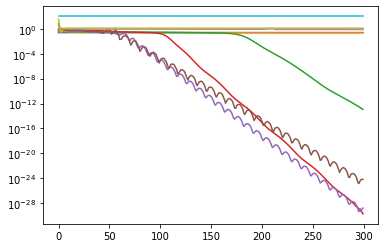

In [86]:
# Grafica
plt.semilogy(np.arange(epochs), np.asarray(MSE).T)
plt.show()

In [87]:
W

[array([ 0.31476626, -0.51785358, -0.53812073,  0.28734271, -0.58723826,
        -0.12734811, -0.17893606, -0.2251282 ,  0.64375616]),
 array([ 0.07988023, -1.14852505, -1.43361283,  0.09570634, -1.34383612,
        -1.26932956,  0.02497487,  0.06692474,  0.43057122]),
 array([ 2.90967525,  2.8665256 , -5.46044041, -2.13252795, -2.10812133,
         0.10043575, -2.54455224, -2.8674251 ,  1.51642333]),
 array([ 3.31463407e+00,  2.97629149e+00, -6.23057937e+00, -2.11937836e+00,
        -1.98680474e+00,  4.86087591e-03, -2.72490103e+00, -2.88326812e+00,
         1.45049077e+00]),
 array([ 2.35545925, -2.09439782, -1.03949603, -4.87557263,  3.20485201,
        -2.93633205,  2.16753252,  2.85819569, -0.71027634]),
 array([ 3.00002631, -2.64184987, -1.33666885, -5.4245634 ,  3.03638134,
        -3.13948319,  1.78265894,  3.09227592, -0.49925035]),
 array([-6.54582212,  1.32034011, -1.55555828, -1.39217   , -1.54622922,
        -3.98288482,  3.78683759,  0.91930146, -0.6713427 ]),
 array([-4.

In [81]:
MSE

[[0.2523039554419577,
  0.25712826339933054,
  0.2577878023413059,
  0.25778240359210014,
  0.25769854399319453,
  0.2576060492451005,
  0.25751302091186173,
  0.25742041081793515,
  0.2573283417364303,
  0.2572368397608221,
  0.2571459195246093,
  0.2570555941449241,
  0.25696587636766455,
  0.25687677868038306,
  0.25678831330484075,
  0.2567004921768702,
  0.2566133269263269,
  0.25652682885866424,
  0.2564410089383202,
  0.25635587777393376,
  0.2562714456053867,
  0.2561877222926525,
  0.25610471730643186,
  0.25602243972054256,
  0.2559408982060285,
  0.25586010102694356,
  0.2557800560377618,
  0.2557007706823579,
  0.25562225199449756,
  0.25554450659977174,
  0.2554675407189039,
  0.25539136017235614,
  0.2553159703861545,
  0.255241376398853,
  0.25516758286955055,
  0.2550945940868749,
  0.2550224139788449,
  0.25495104612352176,
  0.2548804937603584,
  0.25481075980215706,
  0.2547418468475454,
  0.2546737571938809,
  0.25460649285049614,
  0.2545400555521989,
  0.254474446